In [1]:
from core.models import (
    BivariateOUProcess, 
    BivariateCorrelatedBM, 
    BivariateCorrelatedDiffusion, 
    BivariateNonHomogeneous, 
    Fourier4
)
from attributes.attributes import *
from core.MultipleHypTest import MultipleHypTest, UnitRootTest
from core.main import (
    Test,
    TestV2,
    Container,
    Kernel,
    running_maximum,
    graph,
    simulate,
    NoReturn,
    simple_sequence,
    tqdm,
    repl
)

from Data.Reader import Reader
from ContextManager.ModuleContextManager import ImportContextManager
from ContextManager.ModuleContextManager import init_function
from ContextManager.ModuleContextManager import cleanup_function

In [2]:
def Reload(mod) -> type(...) | NoReturn: 
    with ImportContextManager('importlib', init_func=init_function, cleanup_func=cleanup_function) as _f: _f.reload(mod)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TODO
1. Change `main.Test().Gauss()` to use the Fan-Fan-Yiang asymptotic variance.
2. Debug `Reload(mod) -> type(...) | NoReturn`
3. Comment on `simple_sequence(...)`

# Processes
Let us start by defining the processes

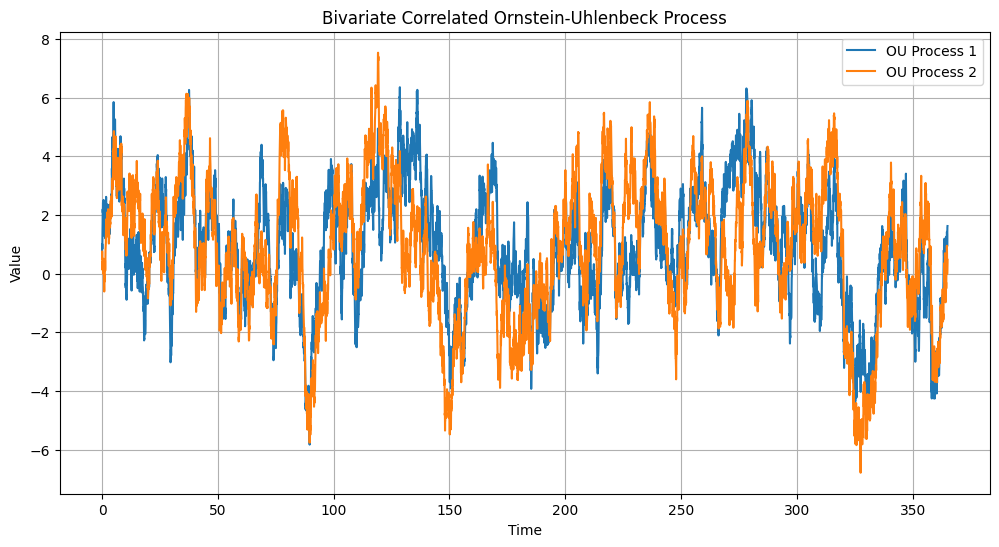

In [5]:
ou_config = {'T':365, 'dt': 1 / 20, 'sigma1': np.sqrt(2), 'sigma2': np.sqrt(2), 'theta1':.2, 'theta2':.2, 'rho':.75}
ou_process = BivariateOUProcess(**ou_config)
ou_process.simulate(seed=1)
ou_process.plot()

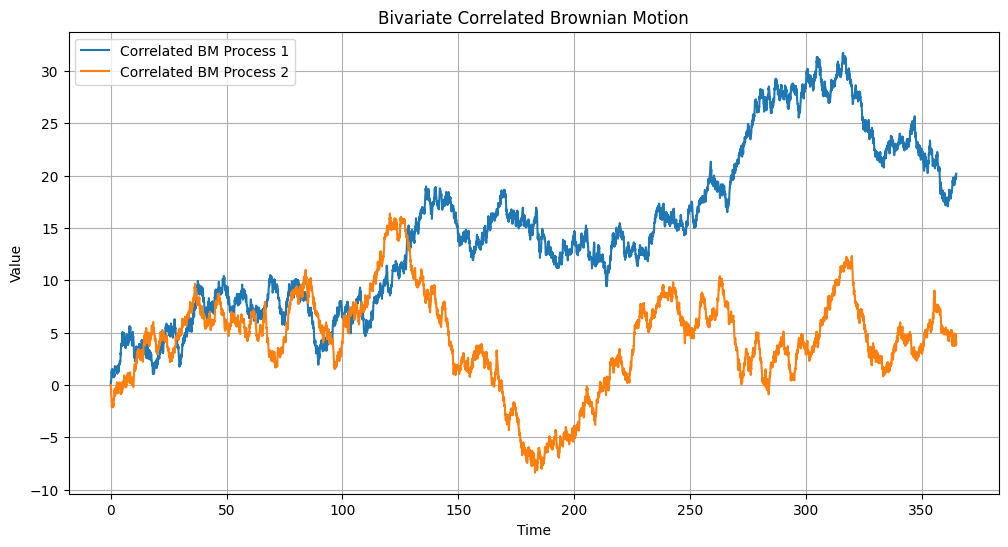

In [6]:
bw_config = {'T':365, 'dt': 1 / 20,'mu1': 0.0, 'mu2': 0.0, 'rho': .0, 'sigma1': 1, 'sigma2': 1}
bw_process = BivariateCorrelatedBM(**bw_config)
bw_process.simulate(seed=1)
bw_process.plot()

In [7]:
# df_config_null = {'T':365, 'dt': 1 / 20,'mu1': 0.0, 'mu2': 0.0, 'rho': 0, 'sigma1': 1, 'sigma2': 1, 'gamma': .6}
# df_process_null = BivariateCorrelatedDiffusion(**df_config_null)
# df_process_null.simulate(seed=1)
# df_process_null.plot()

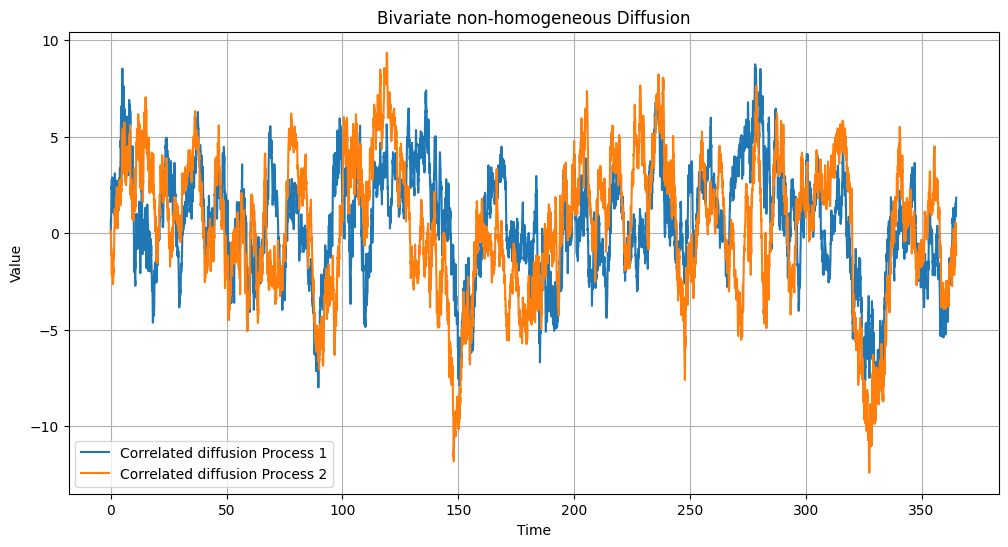

In [8]:
nh_config = {'T':365, 'dt': 1 / 20, 'rho': .5, 'alpha':.5, 'b':.02}
nh_process = BivariateNonHomogeneous(**nh_config)
nh_process.simulate(seed=1)
nh_process.plot()

# Testing
We run the test

In [9]:
X, T, n = ou_process.config()
config_ou_est: dict = {
    'data'  : X,
    'kernel_params' : {
        'bandwidth' : np.sqrt(3) * 9 / ((n ** (1 / 6)) * np.log(n)),
        'n'         : n,
        'T'         : T,
        'kernel'    : Kernel.BaseKernel
    },
    'time_params'   : {
        'bandwidth' : 200 * T / n,
        'n'         : n,
        'T'         : T
    },
}

In [10]:
stationarity_test = TestV2(**config_ou_est)

data :: Ornstein Uhlenbeck
kernel_params
 bandwidth :: 0.3978682657014462
         n :: 7300
         T :: 365
    kernel :: <function Kernel.BaseKernel at 0x0000025EC7AD72E0>
time_params
 bandwidth :: 10.0
         n :: 7300
         T :: 365
   disable :: False
 reachable :: False
       use :: root
kernel_estimates
time_estimates


In [11]:
s = ou_config['sigma1'] ** 2 / (2 * ou_config['theta1'])
f_leb = lambda x, t : (1 / np.sqrt(2 * np.pi * s)) * np.exp(- (x ** 2) / (2 * s))
t_leb = np.linspace(0, ou_process.T, ou_process.N)
dist = (f_leb(X['process 1'], t_leb) * f_leb(X['process 2'], t_leb)).tolist()

In [12]:
stationarity_test.time_domain_smoother(lamb = .99)
stationarity_test.state_domain_smoother(dist = True)
stationarity_test.gauss()

bound, scalar_gauss = stationarity_test.transform_1D_gauss()

100%|██████████| 7300/7300 [00:18<00:00, 384.48it/s]


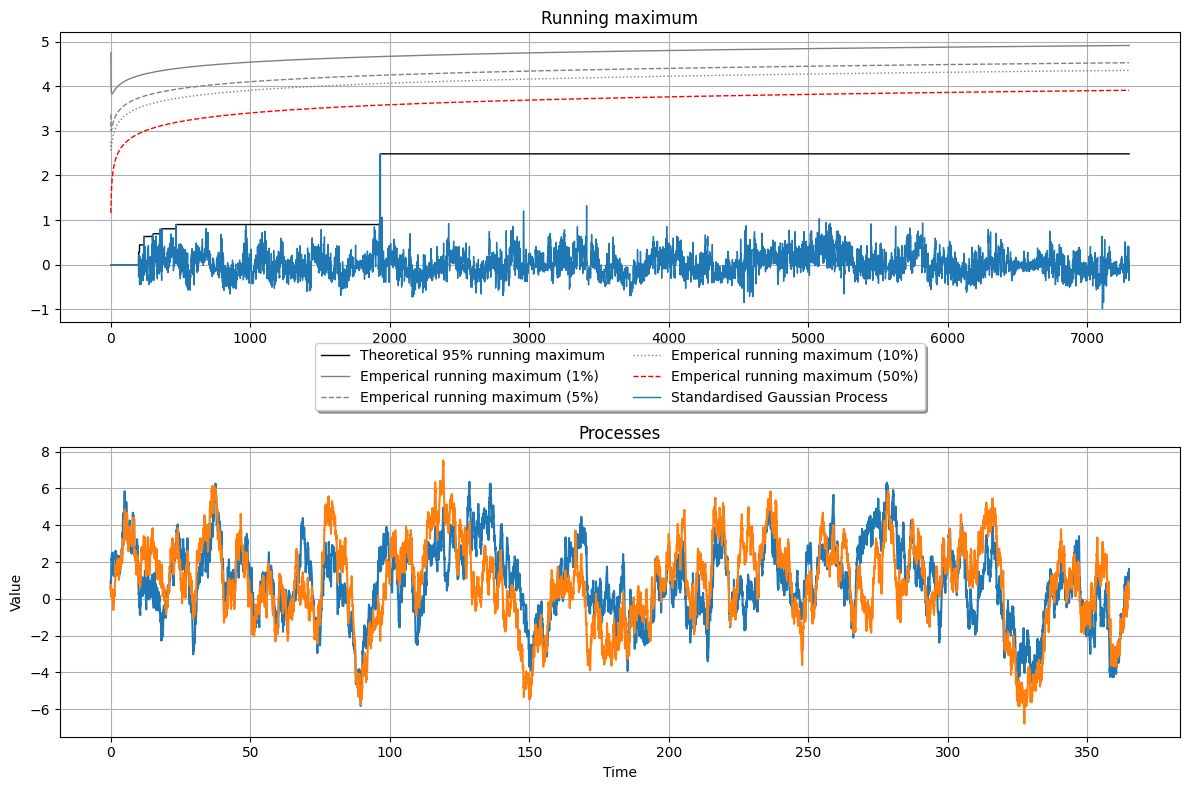

In [13]:
plotting_lib = graph(stationarity_test)
plotting_lib.plot_running_maximum()

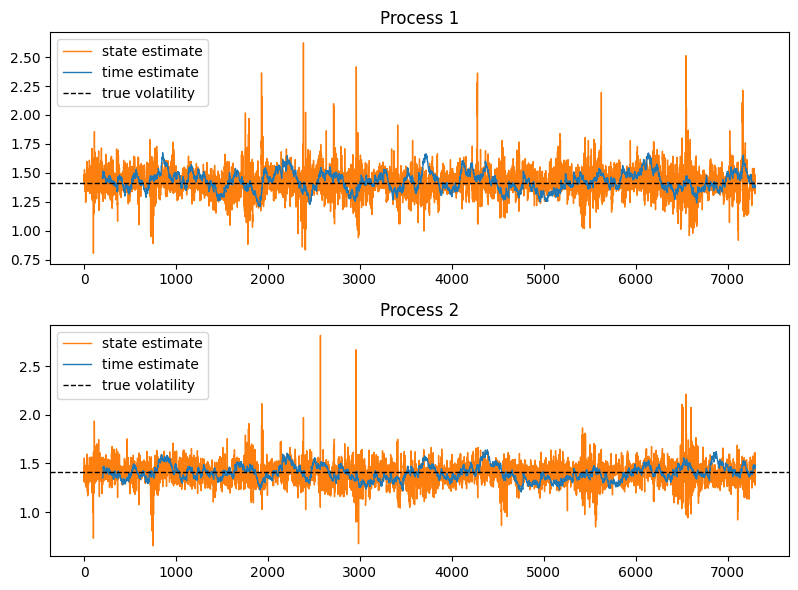

In [14]:
est_time = stationarity_test.time_estimates['estimate']
var_time = stationarity_test.time_estimates['variance']

est_state = stationarity_test.kernel_estimates['estimate']
var_state = stationarity_test.kernel_estimates['variance']

fig, axs = plt.subplots(2,1, figsize = (8,6))
axs[0].plot([item.item(0) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
# plt.plot([item.item(1) ** .5 for item in est_state], c = 'C1', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
axs[0].plot([item.item(0) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[0].axhline(ou_config['sigma1'], c = 'black', ls = '--', lw = 1, label = 'true volatility')
# plt.plot([item.item(1) ** .5 for item in est_time], c = 'C0', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[1].axhline(ou_config['sigma2'], c = 'black', ls = '--', lw = 1, label = 'true volatility')
axs[0].set_title('Process 1')
axs[1].set_title('Process 2')
for ax in axs: ax.legend()
fig.tight_layout()
plt.show()

In [15]:
X, T, n = bw_process.config()
config_bw_est: dict = {
    'data'  : X,
    'kernel_params' : {
        'bandwidth' : np.sqrt(3) * 9 / ((n ** (1 / 6)) * np.log(n)),
        'n'         : n,
        'T'         : T,
        'kernel'    : Kernel.BaseKernel
    },
    'time_params'   : {
        'bandwidth' : 200 * T / n,
        'n'         : n,
        'T'         : T
    },
}

In [16]:
stationarity_test = TestV2(**config_bw_est)

data :: Correlated Brownian motion
kernel_params
 bandwidth :: 0.3978682657014462
         n :: 7300
         T :: 365
    kernel :: <function Kernel.BaseKernel at 0x0000025EC7AD72E0>
time_params
 bandwidth :: 10.0
         n :: 7300
         T :: 365
   disable :: False
 reachable :: False
       use :: root
kernel_estimates
time_estimates


In [17]:
f_leb = lambda x, t : (1 / np.sqrt(2 * np.pi * t)) * np.exp(- (x ** 2) / (2 * t))
t_leb = np.linspace(0, bw_process.T, bw_process.N)
dist = (f_leb(X['process 1'], t_leb) * f_leb(X['process 2'], t_leb)).tolist()
dist = (np.ones_like(t_leb) / 150).tolist()

In [18]:
stationarity_test.time_domain_smoother(lamb = .99)
stationarity_test.state_domain_smoother(dist = dist)
stationarity_test.gauss()

bound, scalar_gauss = stationarity_test.transform_1D_gauss()

100%|██████████| 7300/7300 [00:16<00:00, 448.19it/s]


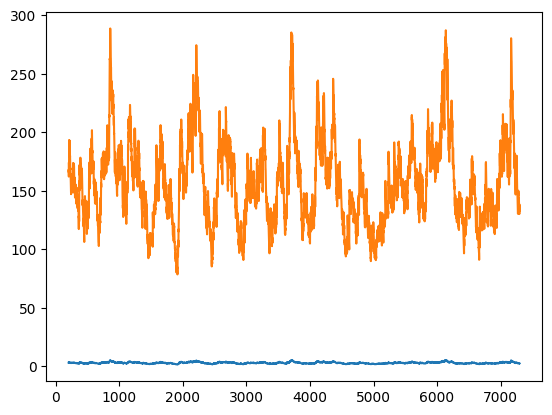

In [19]:
plt.plot([item.item(0) for item in stationarity_test.time_estimates['variance']])
plt.plot([item.item(0) for item in stationarity_test.kernel_estimates['variance']])

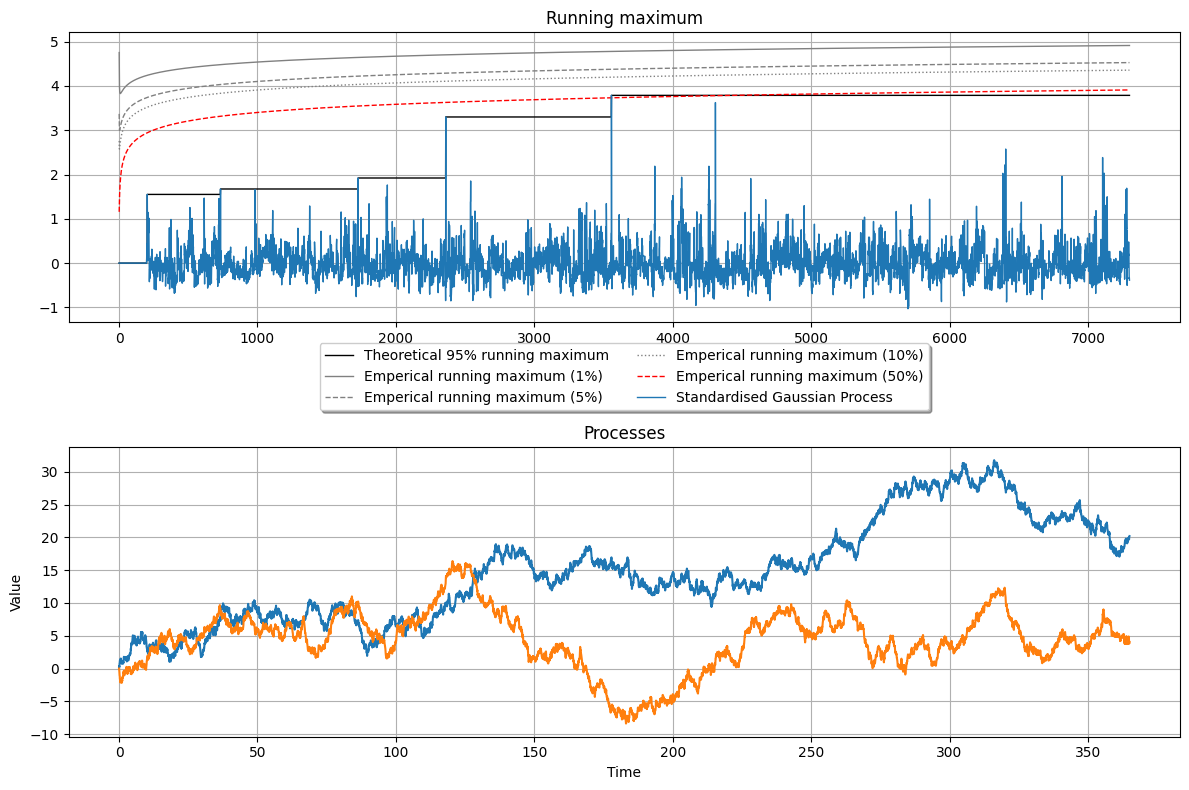

In [20]:
plotting_lib = graph(stationarity_test)
plotting_lib.plot_running_maximum()

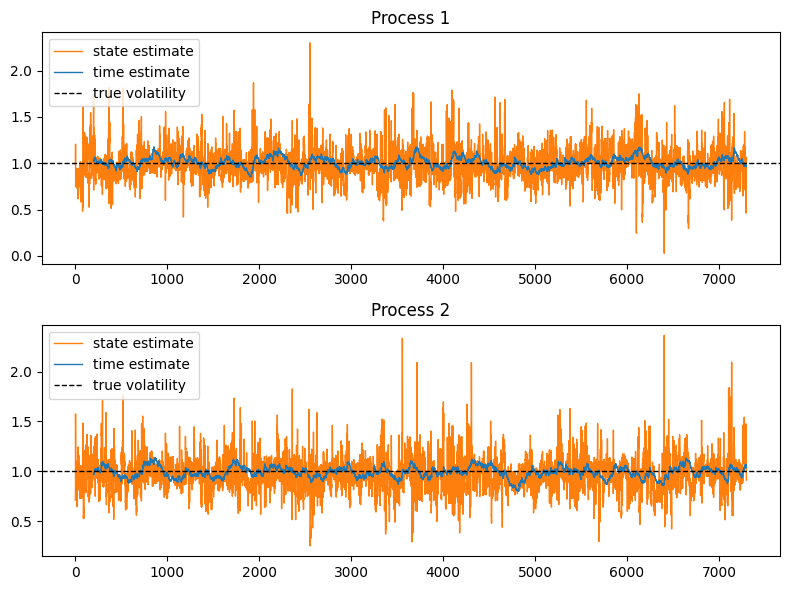

In [21]:
est_time = stationarity_test.time_estimates['estimate']
var_time = stationarity_test.time_estimates['variance']

est_state = stationarity_test.kernel_estimates['estimate']
var_state = stationarity_test.kernel_estimates['variance']

fig, axs = plt.subplots(2,1, figsize = (8,6))
axs[0].plot([item.item(0) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
# plt.plot([item.item(1) ** .5 for item in est_state], c = 'C1', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
axs[0].plot([item.item(0) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[0].axhline(bw_config['sigma1'], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
# plt.plot([item.item(1) ** .5 for item in est_time], c = 'C0', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[1].axhline(bw_config['sigma2'], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
axs[0].set_title('Process 1')
axs[1].set_title('Process 2')
for ax in axs: ax.legend()
fig.tight_layout()
plt.show()

In [22]:
# X, T, n = df_process_null.config()
# config: dict = {
#     'data'  : X,
#     'kernel_params' : {
#         'bandwidth' : 3 / ((n ** (1 / 5))),
#         'n'         : n,
#         'T'         : T,
#         'kernel'    : Kernel.BaseKernel
#     },
#     'time_params'   : {
#         'bandwidth' : 200 * T / n,
#         'n'         : n,
#         'T'         : T
#     },
# }

In [23]:
# stationarity_test = TestV2(**config)

In [24]:
# f_leb = lambda x, t : (1 / np.sqrt(2 * np.pi * t)) * np.exp(- (x ** 2) / (2 * t))
# t_leb = np.linspace(0, bw_process.T, bw_process.N)
# dist = (Fourier4(X['process 1'], df_config_null['gamma']) * Fourier4(X['process 2'], df_config_null['gamma'])).tolist()

In [25]:
# stationarity_test.time_domain_smoother(lamb=.9)
# stationarity_test.state_domain_smoother(dist=dist)
# stationarity_test.gauss()

# bound, scalar_gauss = stationarity_test.transform_1D_gauss()

In [26]:
# plotting_lib = graph(stationarity_test)
# plotting_lib.plot_running_maximum()

In [27]:
# est_time = stationarity_test.time_estimates['estimate']
# var_time = stationarity_test.time_estimates['variance']

# est_state = stationarity_test.kernel_estimates['estimate']
# var_state = stationarity_test.kernel_estimates['variance']

# fig, axs = plt.subplots(2,1, figsize = (8,6))
# axs[0].plot([item.item(0) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
# # plt.plot([item.item(1) ** .5 for item in est_state], c = 'C1', ls = 'dashed', lw = 1)
# axs[1].plot([item.item(3) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
# axs[0].plot([item.item(0) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
# axs[0].plot(df_config_null['sigma1'] * (1 + X['process 1'] ** 2) ** df_config_null['gamma'], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
# # plt.plot([item.item(1) ** .5 for item in est_time], c = 'C0', ls = 'dashed', lw = 1)
# axs[1].plot([item.item(3) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
# axs[1].plot(df_config_null['sigma2'] * (1 + X['process 2'] ** 2) ** df_config_null['gamma'], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
# axs[0].set_title('Process 1')
# axs[1].set_title('Process 2')
# for ax in axs: ax.legend()
# fig.tight_layout()
# plt.show()

In [28]:
X, T, n = nh_process.config()
config_nh_est: dict = {
    'data'  : X,
    'kernel_params' : {
        'bandwidth' : np.sqrt(3) * 9 / ((n ** (1 / 6)) * np.log(n)),
        'n'         : n,
        'T'         : T,
        'kernel'    : Kernel.BaseKernel
    },
    'time_params'   : {
        'bandwidth' : 200 * T / n,
        'n'         : n,
        'T'         : T
    },
}

In [29]:
stationarity_test = TestV2(**config_nh_est)

data :: Correlated Diffusion
kernel_params
 bandwidth :: 0.3978682657014462
         n :: 7300
         T :: 365
    kernel :: <function Kernel.BaseKernel at 0x0000025EC7AD72E0>
time_params
 bandwidth :: 10.0
         n :: 7300
         T :: 365
   disable :: False
 reachable :: False
       use :: root
kernel_estimates
time_estimates


In [30]:
stationarity_test.time_domain_smoother(lamb=.99)
stationarity_test.state_domain_smoother(dist=True)
stationarity_test.gauss()

bound, scalar_gauss = stationarity_test.transform_1D_gauss()

100%|██████████| 7300/7300 [00:16<00:00, 431.46it/s]


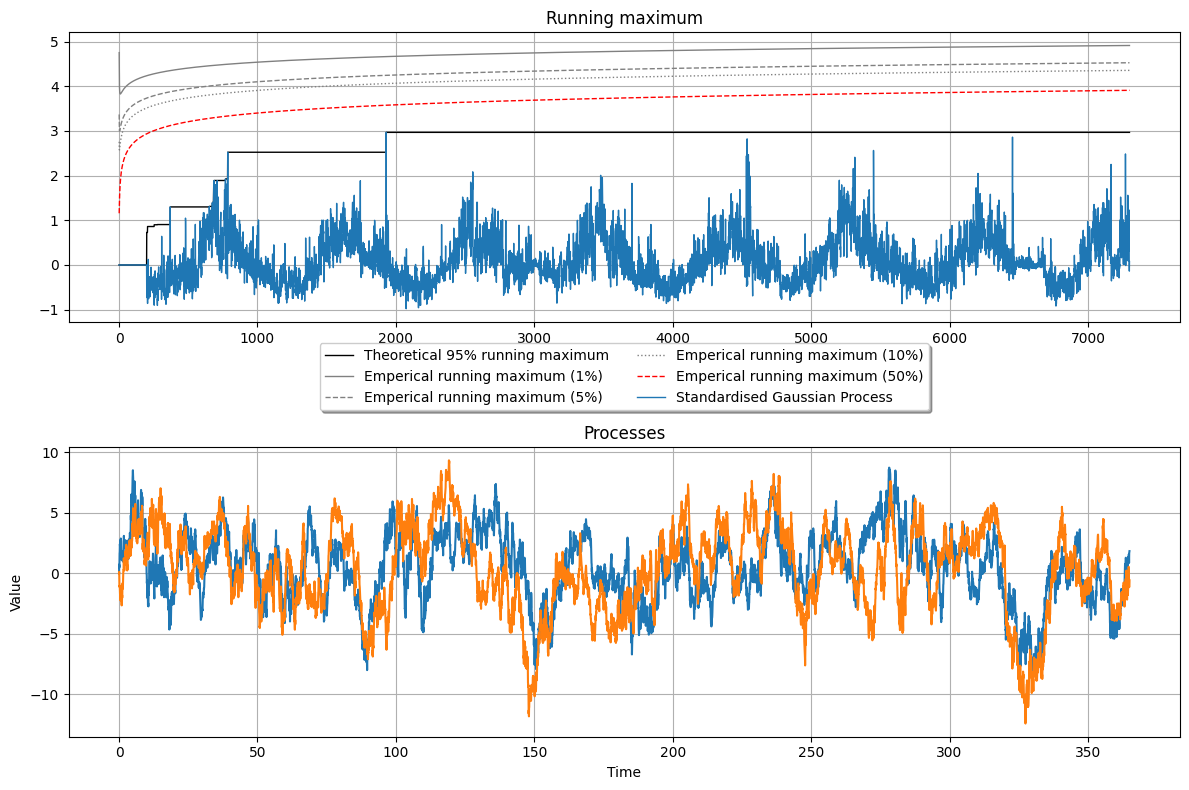

In [31]:
plotting_lib = graph(stationarity_test)
plotting_lib.plot_running_maximum()

In [32]:
@staticmethod
def mu(x,t): return nh_process.mu(x,t)
@staticmethod
def sigm(t): return nh_process.sigm(t)

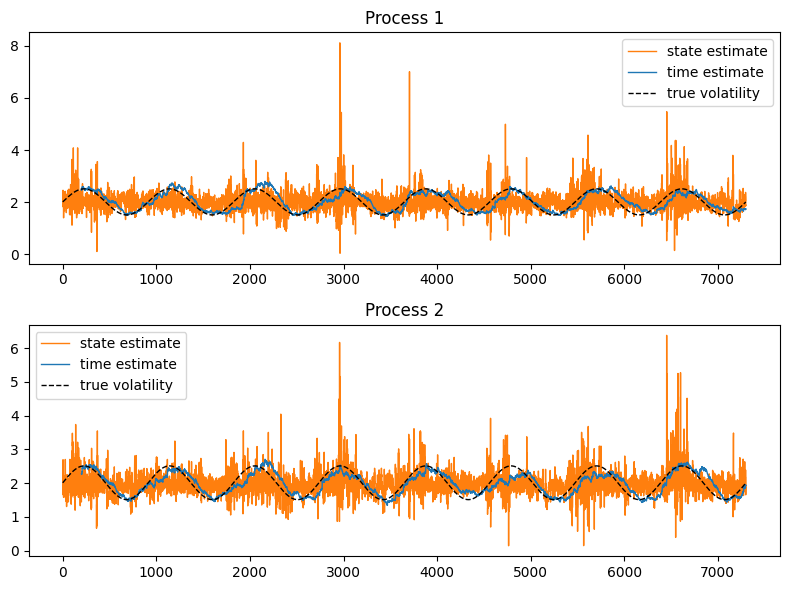

In [33]:
est_time = stationarity_test.time_estimates['estimate']
var_time = stationarity_test.time_estimates['variance']

est_state = stationarity_test.kernel_estimates['estimate']
var_state = stationarity_test.kernel_estimates['variance']

fig, axs = plt.subplots(2,1, figsize = (8,6))
axs[0].plot([item.item(0) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
# plt.plot([item.item(1) ** .5 for item in est_state], c = 'C1', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
axs[0].plot([item.item(0) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[0].plot([sigm(t) for t in np.arange(0, T, T / n)], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
# plt.plot([item.item(1) ** .5 for item in est_time], c = 'C0', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[1].plot([sigm(t) for t in np.arange(0, T, T / n)], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
axs[0].set_title('Process 1')
axs[1].set_title('Process 2')
for ax in axs: ax.legend()
fig.tight_layout()
plt.show()

# Simulation
We can also run multiple tests to check for the sample properties

In [33]:
# We can supply a seed in order to get the same results under the same settings as to validate the results.
number_of_runs = 200
seed = np.arange(1, number_of_runs + 1, 1).tolist()

In [34]:
def sim(number_of_runs, config, dist, est_config = {}, ProcessGenerator = BivariateOUProcess, save = True, name = 'Simulation', seed = None, **kwargs):
    """
    A simple function to simulate and save data
    """
    if not seed: 
        seed = np.arange(1, number_of_runs + 1, 1).tolist()
        print(f'Custom seed set: [1, ..., {number_of_runs}] (global.standard.standard_seed)')
    simulator = simulate(
        number_of_runs=number_of_runs, 
        config = config,
        est_config = est_config,
        ProcessGenerator = ProcessGenerator
        )
    simulator.run(show_object = False, disable = True, seed = seed, time_kwargs = {'lamb':.99}, state_kwargs={'dist':dist}, **kwargs)
    simulator.plot_results()
    simulator.summary(alphas = [.90,.95,.99])

    if save:
        df_process = pd.DataFrame()
        df_gauss = pd.DataFrame()

        for key, val in simulator.results.items():
            if key != 'bound':
                df_process[[key + '_1', key + '_2']] = val['process']
                df_gauss[key] = val['gauss']
        df_process.to_csv('Simulations\\{}_{}_process_{}_{}.csv'.format(name, ProcessGenerator.__name__, number_of_runs, config.get('T')))
        df_gauss.to_csv('Simulations\\{}_{}_gauss_{}_{}.csv'.format(name, ProcessGenerator.__name__, number_of_runs, config.get('T')))

In [35]:
run_on_call: bool = True # Prevents the already run simulations to run again:

## Simulations:
NOTE: the simulations are of complexity $O(n\log n)$ and so total running time takes between 12 to 24 hours, depending on the capacity and power of the machine.

#### Simulation for the Ornstein-Uhlenbeck process

Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 365
        dt :: 0.05
    sigma1 :: 1.4142135623730951
    sigma2 :: 1.4142135623730951
    theta1 :: 0.2
    theta2 :: 0.2
       rho :: 0.75
est_config
ProcessGenerator :: <class 'core.models.BivariateOUProcess'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [1:36:03<00:00, 28.82s/it]


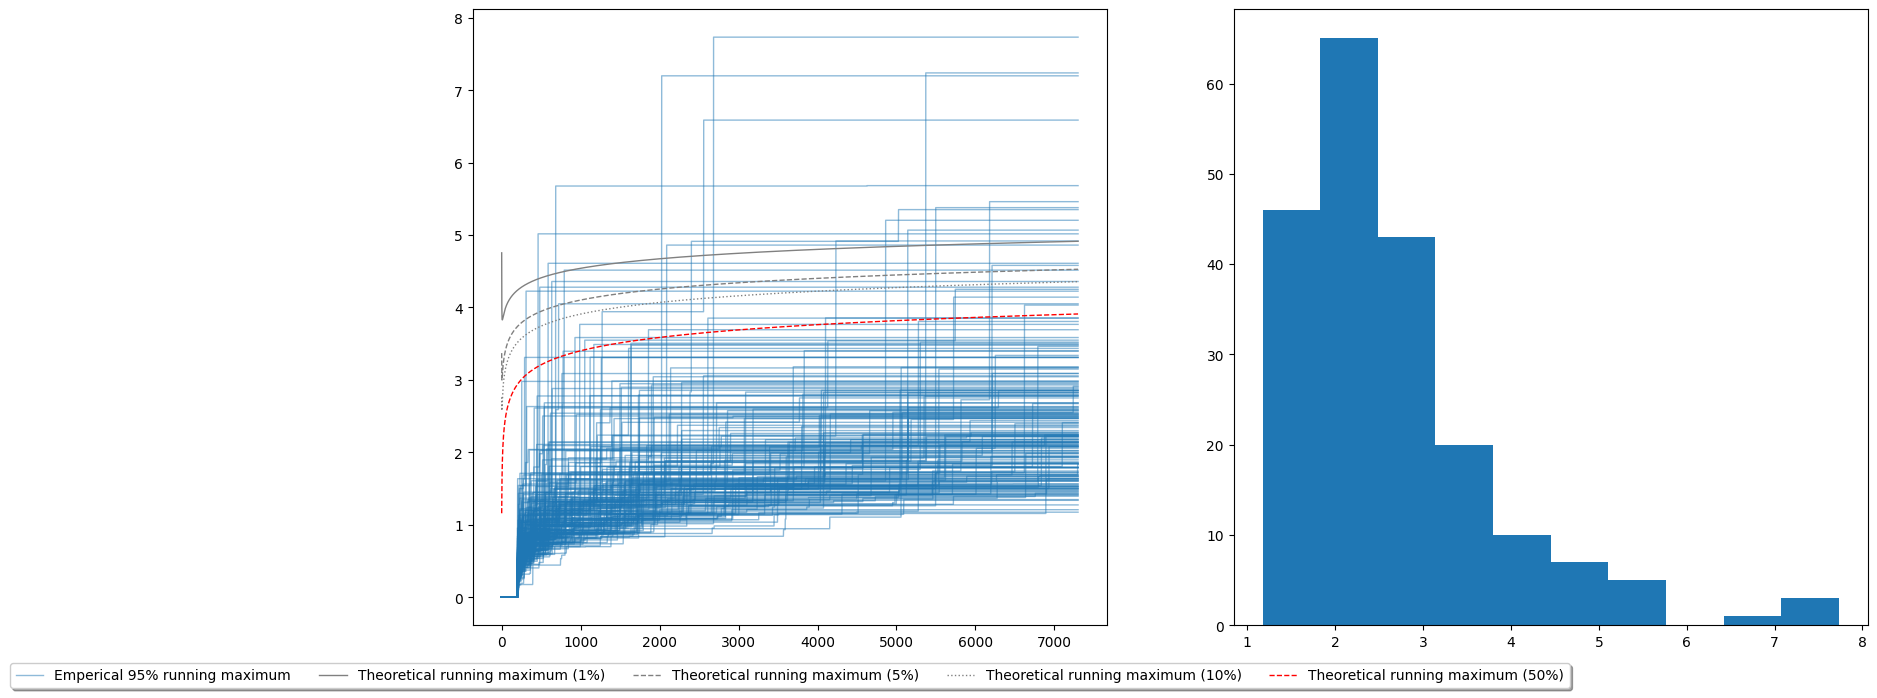

Number of runs: 200, rejection rate: 8.5% (α = 90.0%)
Number of runs: 200, rejection rate: 7.5% (α = 95.0%)
Number of runs: 200, rejection rate: 6.0% (α = 99.0%)


In [36]:
ou_config_365 = {'T':365, 'dt': 1 / 20, 'sigma1': np.sqrt(2), 'sigma2': np.sqrt(2), 'theta1':.2, 'theta2':.2, 'rho':.75}
sim(number_of_runs, ou_config_365, True, ProcessGenerator = BivariateOUProcess, name = 'Simulation')

Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 50
        dt :: 0.05
    sigma1 :: 1.4142135623730951
    sigma2 :: 1.4142135623730951
    theta1 :: 0.2
    theta2 :: 0.2
       rho :: 0.75
est_config
ProcessGenerator :: <class 'core.models.BivariateOUProcess'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [08:00<00:00,  2.40s/it]


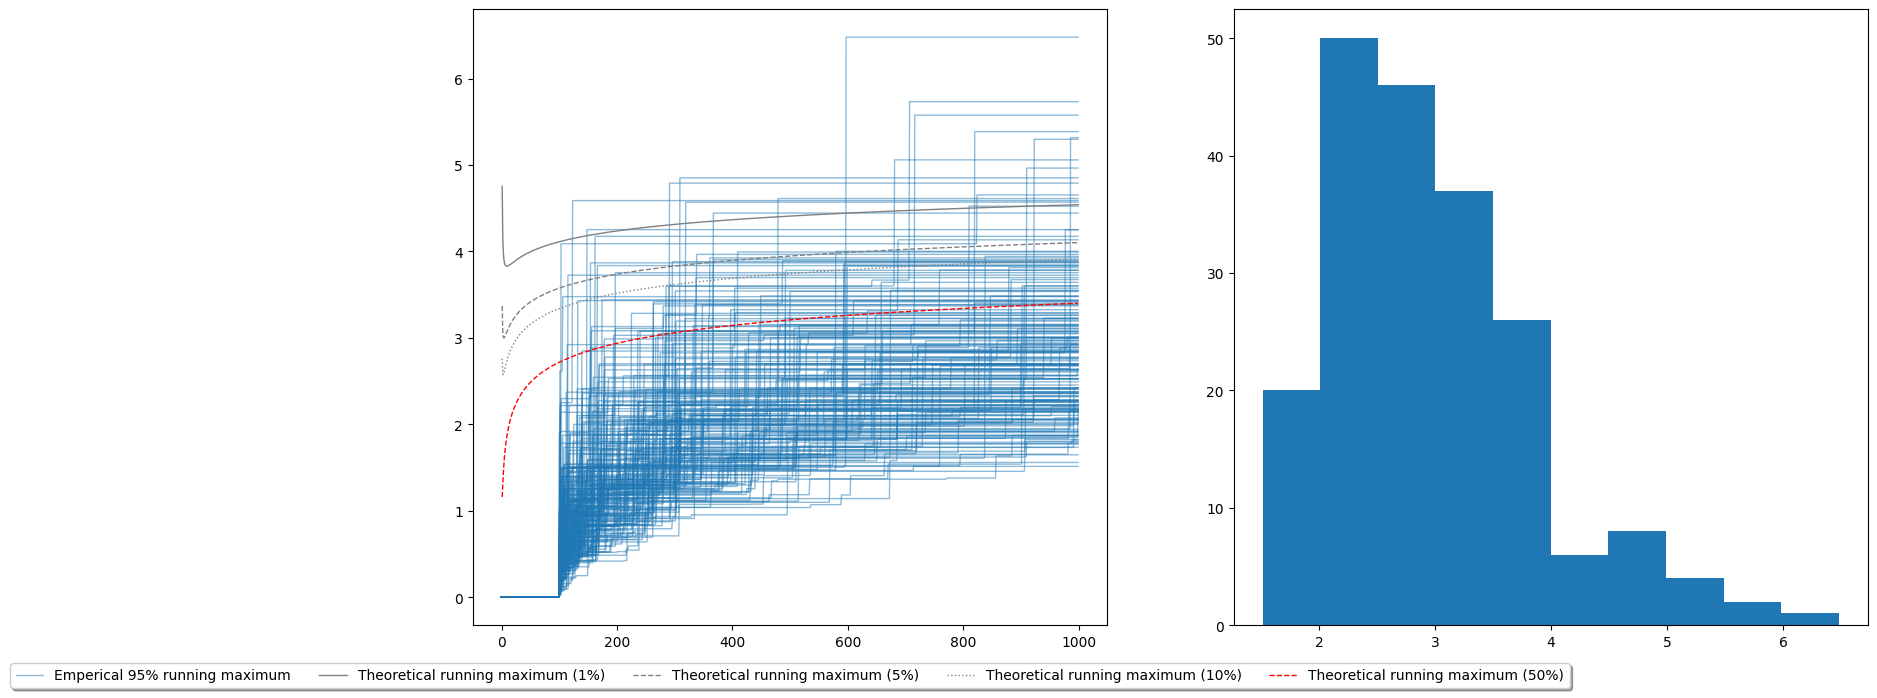

Number of runs: 200, rejection rate: 12.5% (α = 90.0%)
Number of runs: 200, rejection rate: 10.0% (α = 95.0%)
Number of runs: 200, rejection rate: 7.0% (α = 99.0%)
Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 150
        dt :: 0.05
    sigma1 :: 1.4142135623730951
    sigma2 :: 1.4142135623730951
    theta1 :: 0.2
    theta2 :: 0.2
       rho :: 0.75
est_config
ProcessGenerator :: <class 'core.models.BivariateOUProcess'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [27:31<00:00,  8.26s/it]


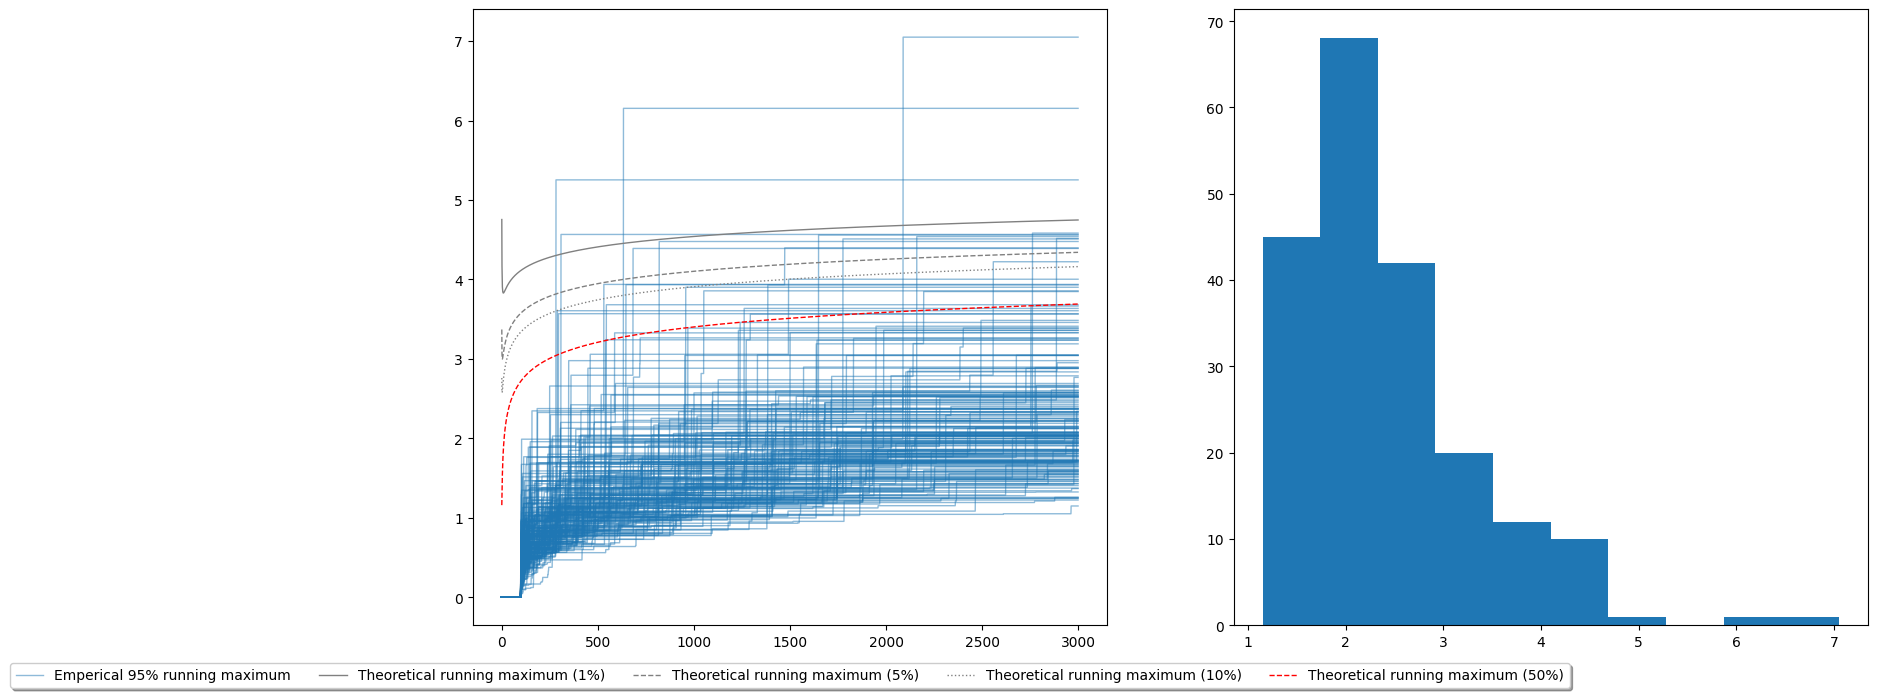

Number of runs: 200, rejection rate: 6.5% (α = 90.0%)
Number of runs: 200, rejection rate: 6.0% (α = 95.0%)
Number of runs: 200, rejection rate: 1.5% (α = 99.0%)
Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 365
        dt :: 0.05
    sigma1 :: 1.4142135623730951
    sigma2 :: 1.4142135623730951
    theta1 :: 0.2
    theta2 :: 0.2
       rho :: 0.75
est_config
ProcessGenerator :: <class 'core.models.BivariateOUProcess'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [1:30:29<00:00, 27.15s/it]


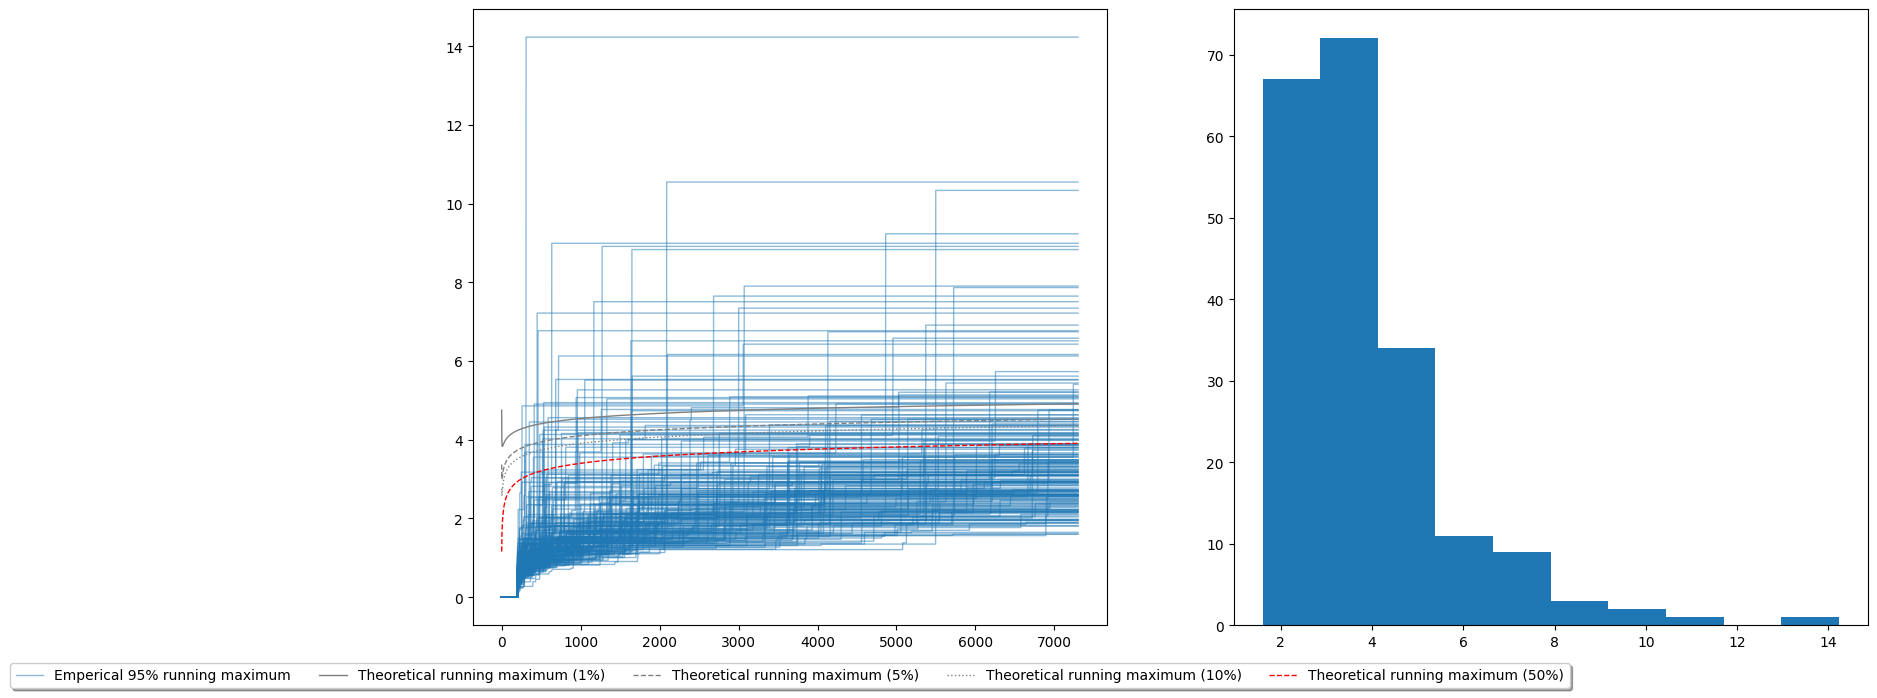

Number of runs: 200, rejection rate: 26.5% (α = 90.0%)
Number of runs: 200, rejection rate: 22.5% (α = 95.0%)
Number of runs: 200, rejection rate: 18.0% (α = 99.0%)


In [55]:
if run_on_call:
    ou_config_50 = {'T':50, 'dt': 1 / 20, 'sigma1': np.sqrt(2), 'sigma2': np.sqrt(2), 'theta1':.2, 'theta2':.2, 'rho':.75}
    sim(number_of_runs, ou_config_50, True, ProcessGenerator = BivariateOUProcess)

    ou_config_150 = {'T':150, 'dt': 1 / 20, 'sigma1': np.sqrt(2), 'sigma2': np.sqrt(2), 'theta1':.2, 'theta2':.2, 'rho':.75}
    sim(number_of_runs, ou_config_150, True, ProcessGenerator = BivariateOUProcess)

    ou_config_365 = {'T':365, 'dt': 1 / 20, 'sigma1': np.sqrt(2), 'sigma2': np.sqrt(2), 'theta1':.2, 'theta2':.2, 'rho':.75}
    sim(number_of_runs, ou_config_365, True, ProcessGenerator = BivariateOUProcess, name = 'Simulation')

#### Simulation for the planar $(\tilde{\mathcal{F}}_t)_{t\geq 0}$-Brownian motion process

Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 50
        dt :: 0.05
       mu1 :: 0.0
       mu2 :: 0.0
       rho :: 0.0
    sigma1 :: 1
    sigma2 :: 1
est_config
ProcessGenerator :: <class 'core.models.BivariateCorrelatedBM'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [07:25<00:00,  2.23s/it]


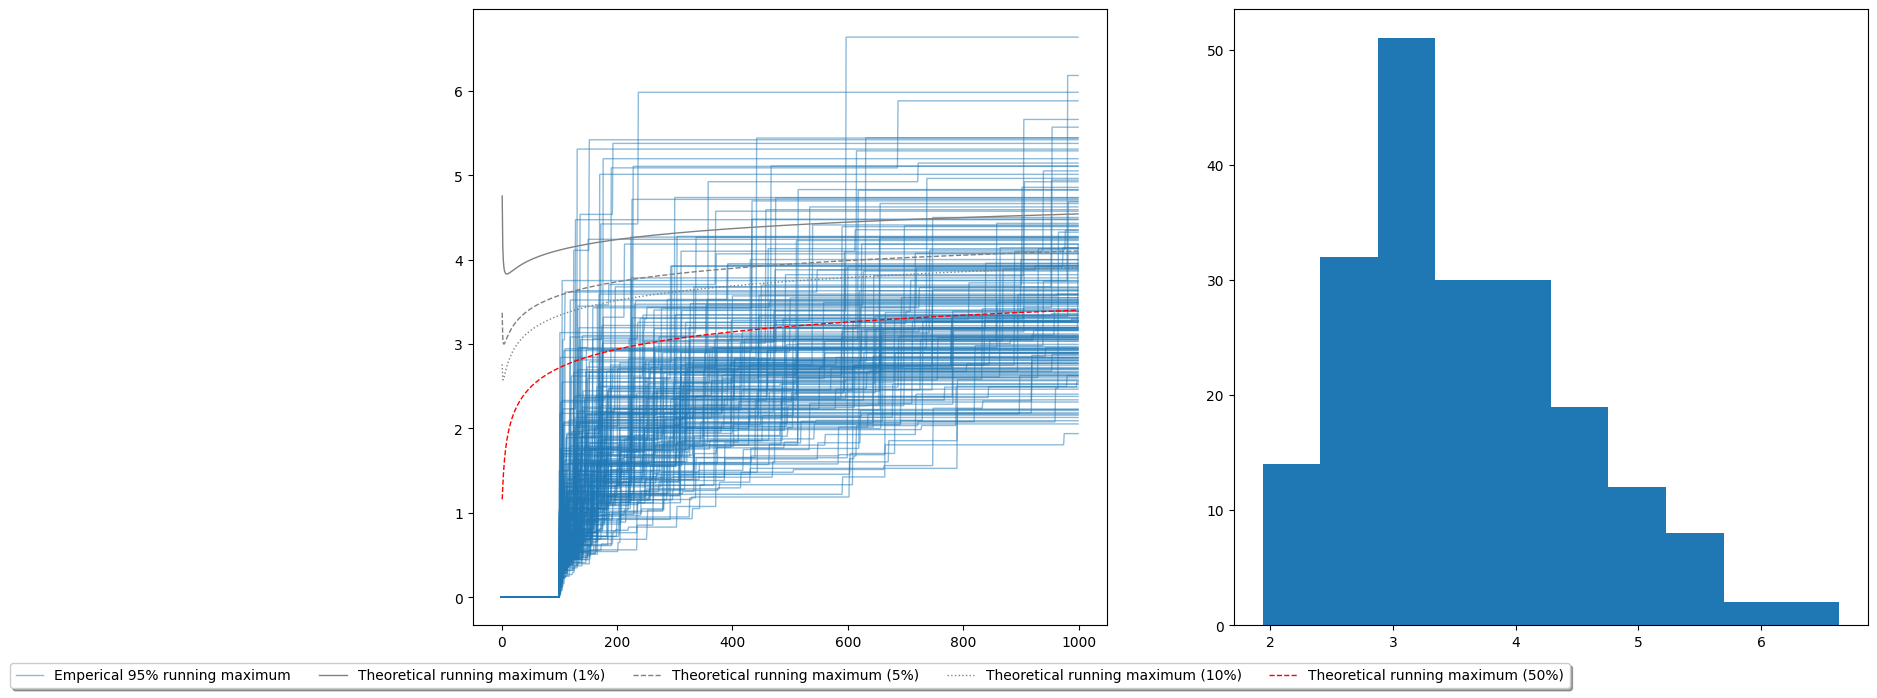

Number of runs: 200, rejection rate: 33.5% (α = 90.0%)
Number of runs: 200, rejection rate: 28.0% (α = 95.0%)
Number of runs: 200, rejection rate: 16.5% (α = 99.0%)
Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 150
        dt :: 0.05
       mu1 :: 0.0
       mu2 :: 0.0
       rho :: 0.0
    sigma1 :: 1
    sigma2 :: 1
est_config
ProcessGenerator :: <class 'core.models.BivariateCorrelatedBM'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [23:44<00:00,  7.12s/it]


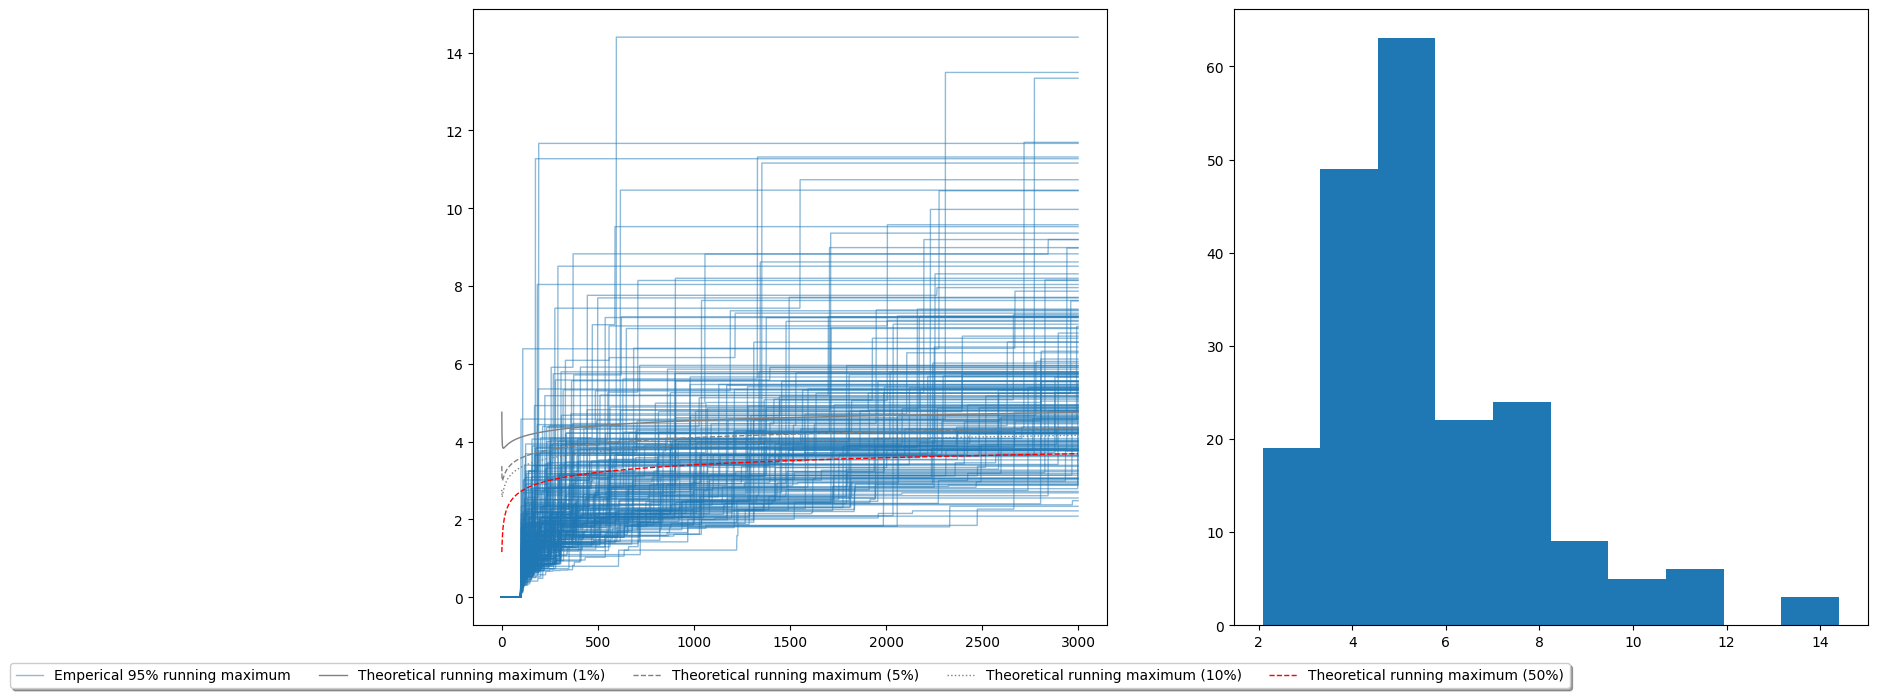

Number of runs: 200, rejection rate: 76.5% (α = 90.0%)
Number of runs: 200, rejection rate: 69.5% (α = 95.0%)
Number of runs: 200, rejection rate: 61.5% (α = 99.0%)
Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 365
        dt :: 0.05
       mu1 :: 0.0
       mu2 :: 0.0
       rho :: 0.0
    sigma1 :: 1
    sigma2 :: 1
est_config
ProcessGenerator :: <class 'core.models.BivariateCorrelatedBM'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [1:07:01<00:00, 20.11s/it]


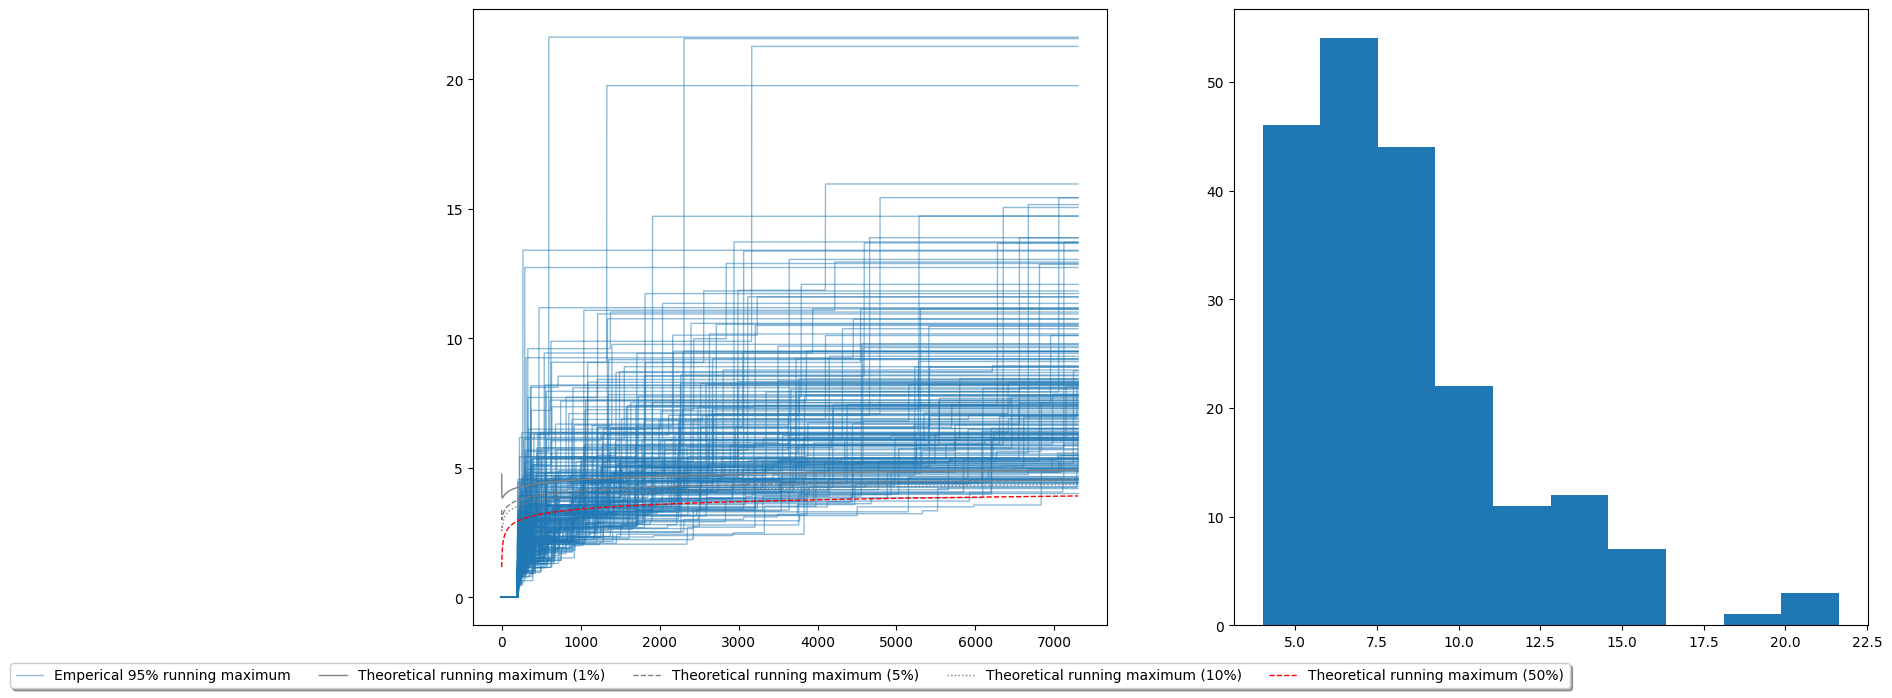

Number of runs: 200, rejection rate: 98.5% (α = 90.0%)
Number of runs: 200, rejection rate: 95.5% (α = 95.0%)
Number of runs: 200, rejection rate: 90.0% (α = 99.0%)


In [37]:
if run_on_call:
    bw_config_50 = {'T': 50, 'dt': 0.05, 'mu1': 0.0, 'mu2': 0.0, 'rho': 0.0, 'sigma1': 1, 'sigma2': 1}
    dist = (np.ones(int(bw_config_50['T'] / bw_config_50['dt'])) / 50).tolist()
    sim(number_of_runs, bw_config_50, dist, ProcessGenerator = BivariateCorrelatedBM)

    bw_config_150 = {'T': 150, 'dt': 0.05, 'mu1': 0.0, 'mu2': 0.0, 'rho': 0.0, 'sigma1': 1, 'sigma2': 1}
    dist = (np.ones(int(bw_config_150['T'] / bw_config_150['dt'])) / 50).tolist()
    sim(number_of_runs, bw_config_150, dist, ProcessGenerator = BivariateCorrelatedBM)

    bw_config_365 = {'T': 365, 'dt': 0.05, 'mu1': 0.0, 'mu2': 0.0, 'rho': 0.0, 'sigma1': 1, 'sigma2': 1}
    dist = (np.ones(int(bw_config_365['T'] / bw_config_365['dt'])) / 50).tolist()
    sim(number_of_runs, bw_config_365, dist, ProcessGenerator = BivariateCorrelatedBM)


#### Simulation for the Inhomogeneous diffusion process

In [ ]:
if run_on_call:    
    nh_config_50 = {'T': 50, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.3, 'b': 0.01}
    sim(number_of_runs, nh_config_50, dist, ProcessGenerator = BivariateNonHomogeneous)

    nh_config_150 = {'T': 150, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.3, 'b': 0.01}
    sim(number_of_runs, nh_config_150, False, ProcessGenerator = BivariateNonHomogeneous)

    nh_config_365 = {'T': 365, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.3, 'b': 0.01}
    sim(number_of_runs, nh_config_365, dist, ProcessGenerator = BivariateNonHomogeneous)


Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 50
        dt :: 0.05
       rho :: 0.5
     alpha :: 0.5
         b :: 0.1
est_config
ProcessGenerator :: <class 'core.models.BivariateNonHomogeneous'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [07:41<00:00,  2.31s/it]


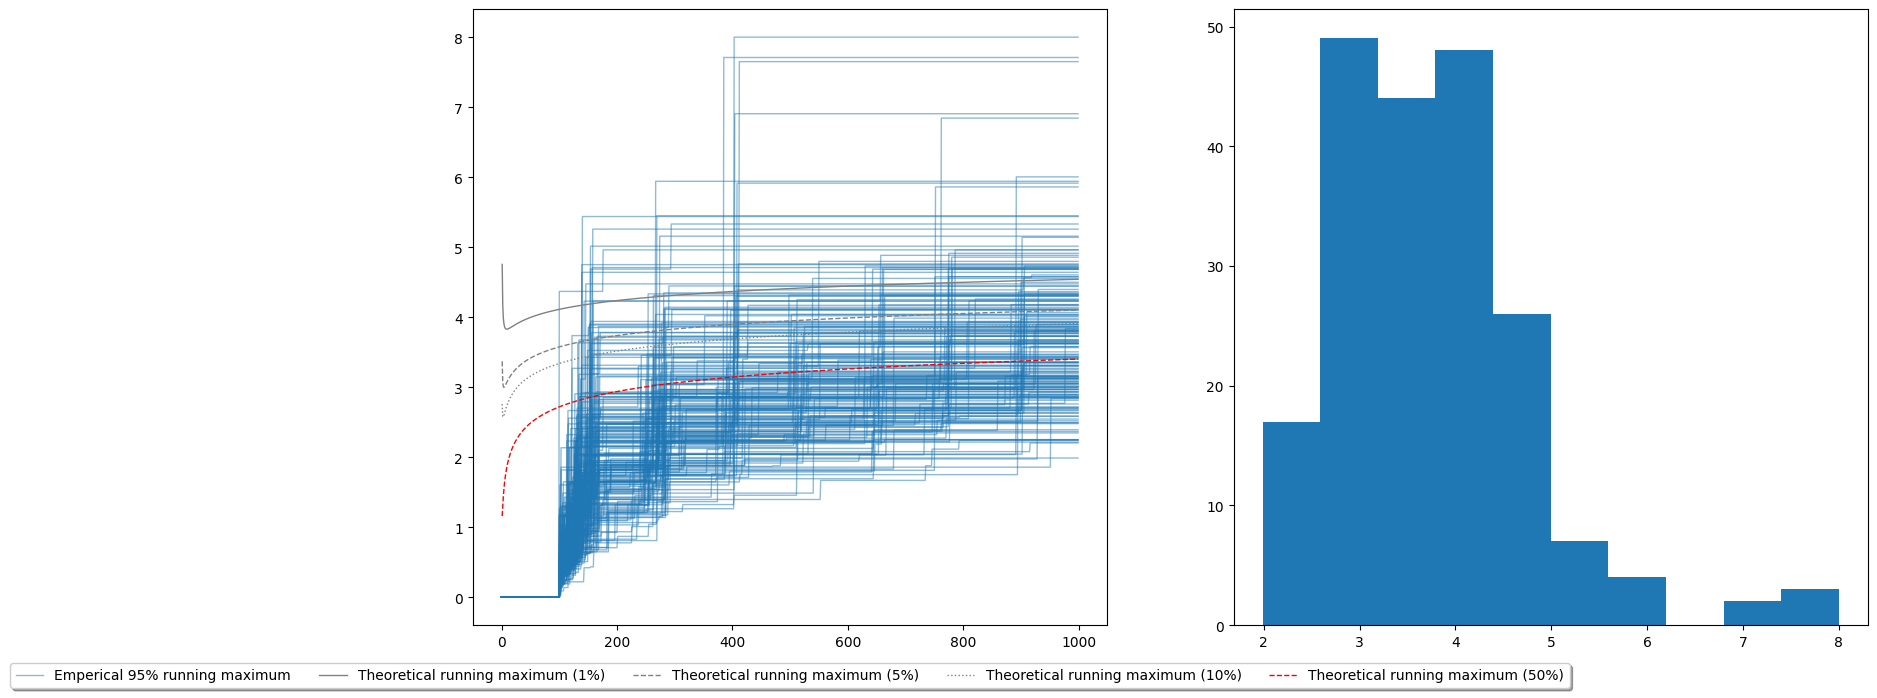

Number of runs: 200, rejection rate: 37.5% (α = 90.0%)
Number of runs: 200, rejection rate: 31.5% (α = 95.0%)
Number of runs: 200, rejection rate: 18.5% (α = 99.0%)
Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 150
        dt :: 0.05
       rho :: 0.5
     alpha :: 0.5
         b :: 0.1
est_config
ProcessGenerator :: <class 'core.models.BivariateNonHomogeneous'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [25:45<00:00,  7.73s/it]


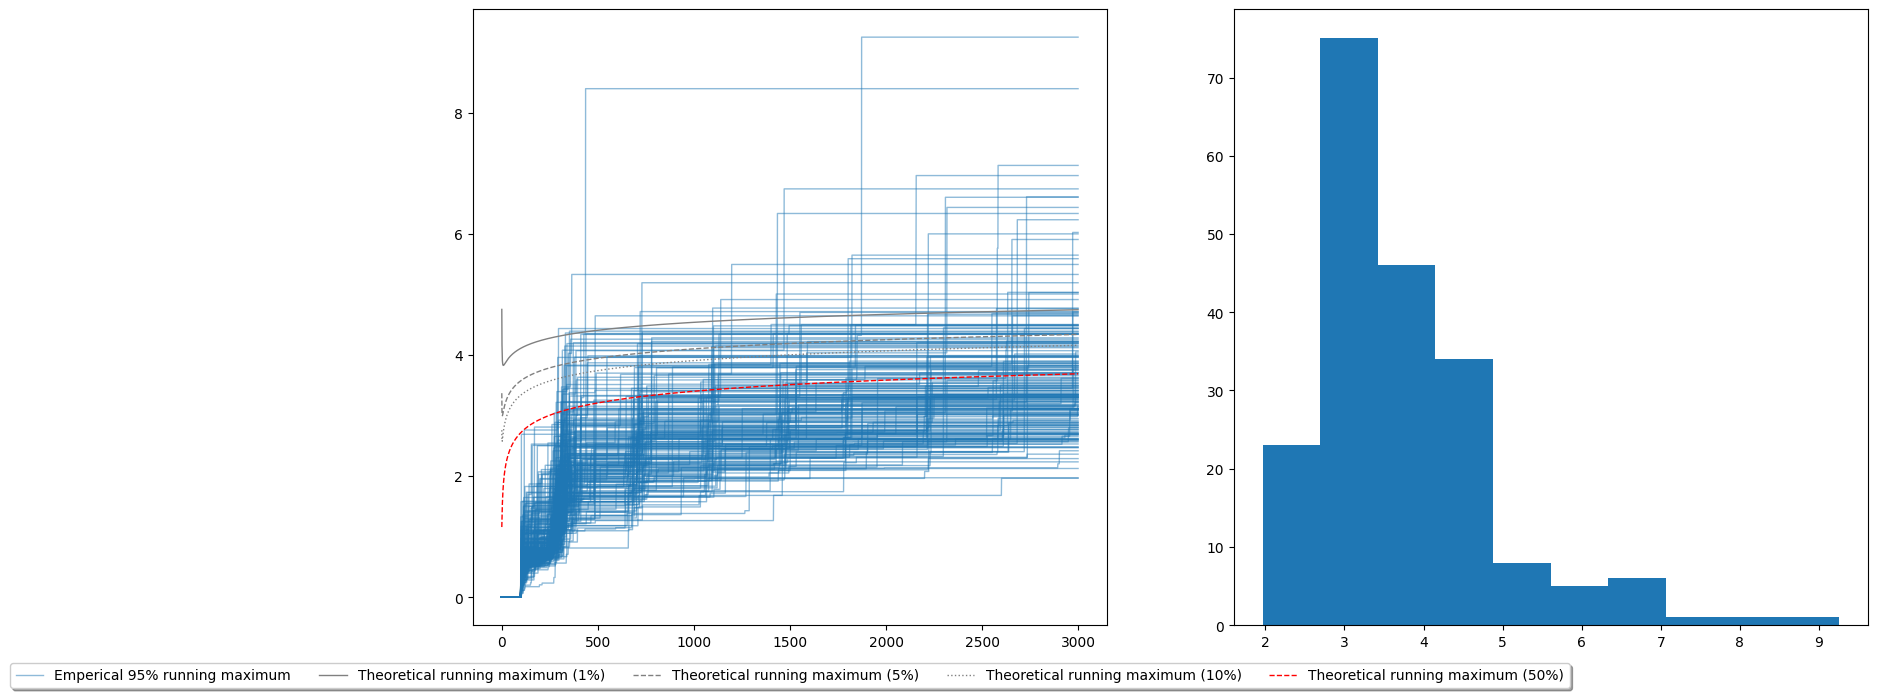

Number of runs: 200, rejection rate: 27.5% (α = 90.0%)
Number of runs: 200, rejection rate: 22.5% (α = 95.0%)
Number of runs: 200, rejection rate: 12.0% (α = 99.0%)
Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 365
        dt :: 0.05
       rho :: 0.5
     alpha :: 0.5
         b :: 0.1
est_config
ProcessGenerator :: <class 'core.models.BivariateNonHomogeneous'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [1:27:05<00:00, 26.13s/it]


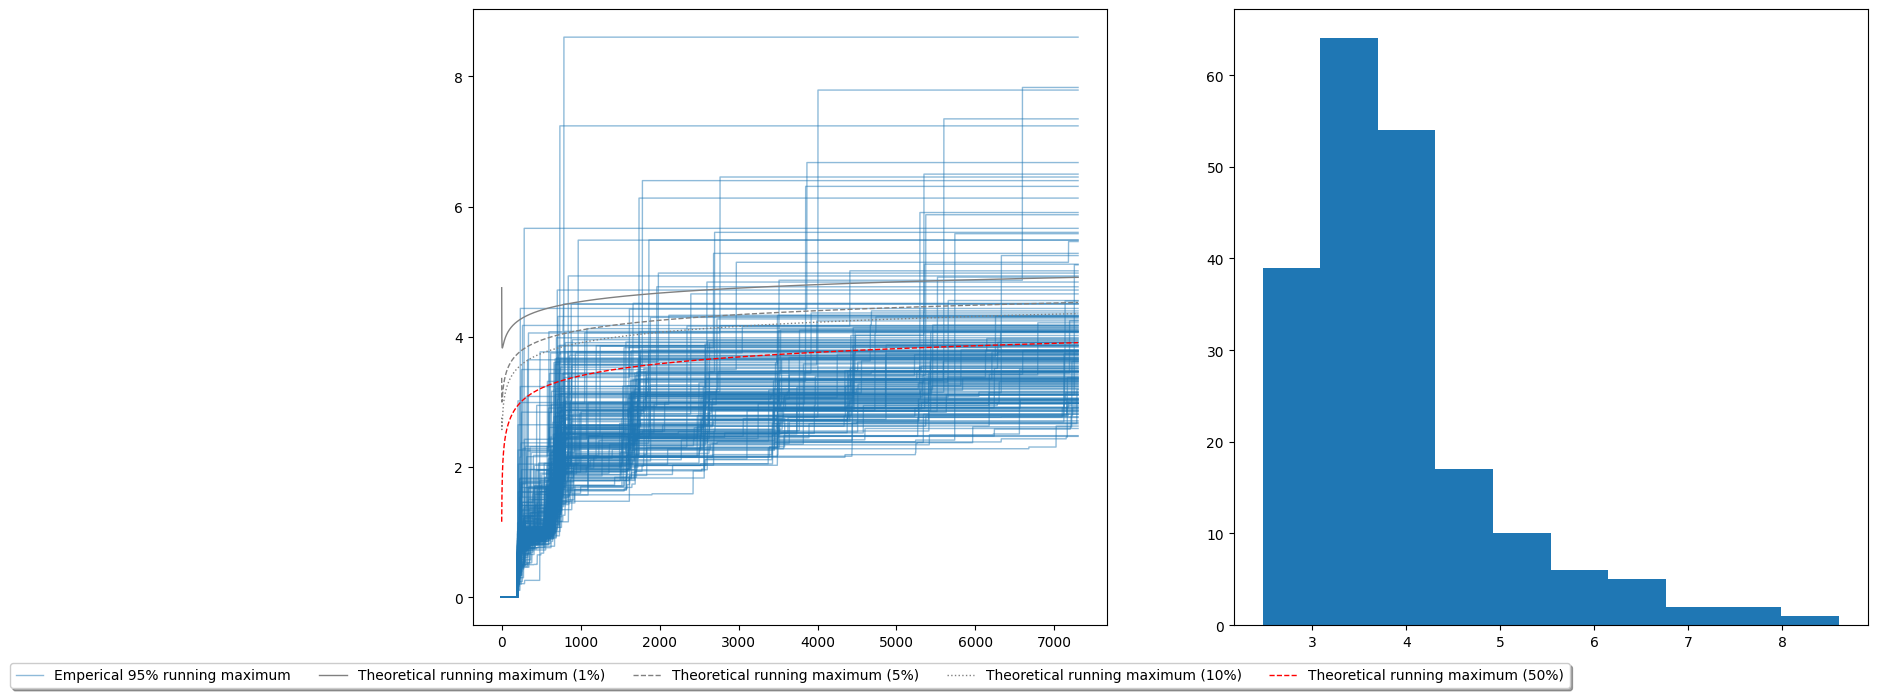

Number of runs: 200, rejection rate: 19.5% (α = 90.0%)
Number of runs: 200, rejection rate: 16.5% (α = 95.0%)
Number of runs: 200, rejection rate: 13.5% (α = 99.0%)


In [38]:
if run_on_call:     
    nh_config_50 = {'T': 50, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.5, 'b': 0.1}
    sim(number_of_runs, nh_config_50, True, ProcessGenerator = BivariateNonHomogeneous, name = 'Simulation')

    nh_config_150 = {'T': 150, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.5, 'b': 0.1}
    sim(number_of_runs, nh_config_150, True, ProcessGenerator = BivariateNonHomogeneous, name = 'Simulation')

    nh_config_365 = {'T': 365, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.5, 'b': 0.1}
    sim(number_of_runs, nh_config_365, True, ProcessGenerator = BivariateNonHomogeneous, name = 'Simulation')

##### We can also call the Benjamini-Hochberg-Yekutieli method using the `core.MultipleHypTest.MultipleHypTest(...)` class

To do so, we call on the stores simulation results, located at ..\\\\data\\\\simulation_file_name.csv.

In [132]:
files: list = [
    # Bivariate Ornstein-Uhlenbeck process for k = 50, 150 and 365
    '\\Simulation_BivariateOUProcess_gauss_200_50.csv',
    '\\Simulation_BivariateOUProcess_gauss_200_150.csv',
    '\\Simulation_BivariateOUProcess_gauss_200_365.csv',

    # Bivariate correlated Brownian motion for k = 50, 150 and 365
    '\\Simulation_BivariateCorrelatedBM_gauss_200_50.csv',
    '\\Simulation_BivariateCorrelatedBM_gauss_200_150.csv',
    '\\Simulation_BivariateCorrelatedBM_gauss_200_365.csv',

    # Bivariate inhomogeneous diffusion for k = 50, 150 and 365
    '\\Simulation_BivariateNonHomogeneous_gauss_200_50.csv',
    '\\Simulation_BivariateNonHomogeneous_gauss_200_150.csv',
    '\\Simulation_BivariateNonHomogeneous_gauss_200_365.csv',
       ]

In [131]:
# Download content using the Reader module
content = Reader(files = files)

  0%|          | 0/9 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\dwzun\\OneDrive\\Documenten\\Master Econometrics\\Thesis Honours\\Simulations\\\\Simulation_BivariateOUProcess_gauss_200_50.csv'

In [ ]:
# Loop over files to run running maximum replication
for file in files:
    name = file.replace('_dist','').split('_')[1]
    file = file.replace('\\','')
    repl(content.parsed_files[file], name).summary()

In [ ]:
# Loop over the files to run the Benjamini-Hochberg-Yekutieli procedures
# For sake of brevity, we will only show the results of the OU-process.
for file in files[:1]:
    name = file.replace('_dist','').split('_')[1]
    MultipleHypTest(content.parsed_files[file.replace('\\','')], run_on_call = True, name = name)

In [ ]:
# The class can also be called using a single file
X = content.parsed_files['Simulation_BivariateCorrelatedBM_gauss_200_150.csv']
bhy_test = MultipleHypTest(X, two_sides = True, remove_zero_rows = True)

In [ ]:
# Then, simply call the run method to start the procedure for both methods
bhy_test.run()  # standard sign. values are .1, .05 and .01

#### We can compare the results with the KPSS and Leybourne-McCabe tests.

In [4]:
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings(action = 'ignore') # kpss test trows warnings

In [74]:
process_files: list = [
    # Bivariate Ornstein-Uhlenbeck process for k = 50, 150 and 365
    '\\Simulation_BivariateOUProcess_process_200_50.csv',
    '\\Simulation_BivariateOUProcess_process_200_150.csv',
    '\\Simulation_BivariateOUProcess_process_200_365.csv',

    # Bivariate correlated Brownian motion for k = 50, 150 and 365
    '\\Simulation_BivariateCorrelatedBM_process_200_50.csv',
    '\\Simulation_BivariateCorrelatedBM_process_200_150.csv',
    '\\Simulation_BivariateCorrelatedBM_process_200_365.csv',

    # Bivariate inhomogeneous diffusion for k = 50, 150 and 365
    '\\Simulation_BivariateNonHomogeneous_process_200_50.csv',
    '\\Simulation_BivariateNonHomogeneous_process_200_150.csv',
    '\\Simulation_BivariateNonHomogeneous_process_200_365.csv',
       ]

gauss_files: list = [
    # Bivariate Ornstein-Uhlenbeck process for k = 50, 150 and 365
    '\\Simulation_BivariateOUProcess_gauss_200_50.csv',
    '\\Simulation_BivariateOUProcess_gauss_200_150.csv',
    '\\Simulation_BivariateOUProcess_gauss_200_365.csv',

    # Bivariate correlated Brownian motion for k = 50, 150 and 365
    '\\Simulation_BivariateCorrelatedBM_gauss_200_50.csv',
    '\\Simulation_BivariateCorrelatedBM_gauss_200_150.csv',
    '\\Simulation_BivariateCorrelatedBM_gauss_200_365.csv',

    # Bivariate inhomogeneous diffusion for k = 50, 150 and 365
    '\\Simulation_BivariateNonHomogeneous_gauss_200_50.csv',
    '\\Simulation_BivariateNonHomogeneous_gauss_200_150.csv',
    '\\Simulation_BivariateNonHomogeneous_gauss_200_365.csv',
       ]

In [75]:
content_processes = Reader(process_files)
content_gauss = Reader(gauss_files)

100%|██████████| 9/9 [00:01<00:00,  4.96it/s]


In [76]:
X1 = content_processes.parsed_files['Simulation_BivariateOUProcess_process_200_50.csv']
X2 = content_processes.parsed_files['Simulation_BivariateOUProcess_process_200_150.csv']
X3 = content_processes.parsed_files['Simulation_BivariateOUProcess_process_200_365.csv']

G1 = content_gauss.parsed_files['Simulation_BivariateOUProcess_gauss_200_50.csv']
G2 = content_gauss.parsed_files['Simulation_BivariateOUProcess_gauss_200_150.csv']
G3 = content_gauss.parsed_files['Simulation_BivariateOUProcess_gauss_200_365.csv']

In [77]:
rm_ou_50 = repl(G1, BivariateOUProcess)
rm_ou_50.summary()

rm_ou_150 = repl(G2, BivariateOUProcess)
rm_ou_150.summary()

rm_ou_365 = repl(G3, BivariateOUProcess)
rm_ou_365.summary()

-------------- <class 'core.models.BivariateOUProcess'> --------------
Number of runs: 200, rejection rate: 12.5% (α = 90.0%)
Number of runs: 200, rejection rate: 10.0% (α = 95.0%)
Number of runs: 200, rejection rate: 7.0% (α = 99.0%)

-------------- <class 'core.models.BivariateOUProcess'> --------------
Number of runs: 200, rejection rate: 6.5% (α = 90.0%)
Number of runs: 200, rejection rate: 6.0% (α = 95.0%)
Number of runs: 200, rejection rate: 1.5% (α = 99.0%)

-------------- <class 'core.models.BivariateOUProcess'> --------------
Number of runs: 200, rejection rate: 8.5% (α = 90.0%)
Number of runs: 200, rejection rate: 7.5% (α = 95.0%)
Number of runs: 200, rejection rate: 6.0% (α = 99.0%)



In [78]:
bhy_ou_50 = MultipleHypTest(G1, run_on_call = False, name = 'BivariateOUProcess')
bhy_ou_50.run(q = [.05])

bhy_ou_150 = MultipleHypTest(G2, run_on_call = False, name = 'BivariateOUProcess')
bhy_ou_150.run(q = [.05])

bhy_ou_365 = MultipleHypTest(G3, run_on_call = False, name = 'BivariateOUProcess')
bhy_ou_365.run(q = [.05])

------------------------- BivariateOUProcess -------------------------
MultipleHypTest@Self.run: running [hochberg]...


200it [00:16, 12.12it/s]



Hochberg:
Rejection rate: 10.00% (α =  5.00%)

MultipleHypTest@Self.run: running [yekutieli]...


200it [00:17, 11.29it/s]



Yekutieli:
Rejection rate:  8.00% (α =  5.00%)

-------------------------------Finished-------------------------------
------------------------- BivariateOUProcess -------------------------
MultipleHypTest@Self.run: running [hochberg]...


200it [00:59,  3.35it/s]



Hochberg:
Rejection rate:  6.00% (α =  5.00%)

MultipleHypTest@Self.run: running [yekutieli]...


200it [01:01,  3.25it/s]



Yekutieli:
Rejection rate:  2.00% (α =  5.00%)

-------------------------------Finished-------------------------------
------------------------- BivariateOUProcess -------------------------
MultipleHypTest@Self.run: running [hochberg]...


200it [02:15,  1.47it/s]



Hochberg:
Rejection rate:  8.00% (α =  5.00%)

MultipleHypTest@Self.run: running [yekutieli]...


200it [02:28,  1.35it/s]


Yekutieli:
Rejection rate:  6.00% (α =  5.00%)

-------------------------------Finished-------------------------------


In [79]:
mht_ou_50 = UnitRootTest(processes = X1)
mht_ou_50.run(q = [.05])

mht_ou_150 = UnitRootTest(processes = X2)
mht_ou_150.run(q = [.05])

mht_ou_365 = UnitRootTest(processes = X3)
mht_ou_365.run(q = [.05])

MultipleHypTest@Self.run: running [kpss]...


100%|██████████| 400/400 [00:00<00:00, 898.58it/s]



Kpss:
Rejection rate: 69.00% (α =  5.00%)

MultipleHypTest@Self.run: running [lm]...


100%|██████████| 400/400 [01:07<00:00,  5.90it/s]



Lm:
Rejection rate: 96.00% (α =  5.00%)

-------------------------------Finished-------------------------------
MultipleHypTest@Self.run: running [kpss]...


100%|██████████| 400/400 [00:00<00:00, 1294.35it/s]



Kpss:
Rejection rate: 56.00% (α =  5.00%)

MultipleHypTest@Self.run: running [lm]...


100%|██████████| 400/400 [02:05<00:00,  3.19it/s]



Lm:
Rejection rate: 86.00% (α =  5.00%)

-------------------------------Finished-------------------------------
MultipleHypTest@Self.run: running [kpss]...


100%|██████████| 400/400 [00:00<00:00, 1258.38it/s]



Kpss:
Rejection rate: 36.00% (α =  5.00%)

MultipleHypTest@Self.run: running [lm]...


100%|██████████| 400/400 [04:53<00:00,  1.36it/s]


Lm:
Rejection rate: 74.00% (α =  5.00%)

-------------------------------Finished-------------------------------


In [102]:
X1 = content_processes.parsed_files['Simulation_BivariateCorrelatedBM_process_200_50.csv']
X2 = content_processes.parsed_files['Simulation_BivariateCorrelatedBM_process_200_150.csv']
X3 = content_processes.parsed_files['Simulation_BivariateCorrelatedBM_process_200_365.csv']

G1 = content_gauss.parsed_files['Simulation_BivariateCorrelatedBM_gauss_200_50.csv']
G2 = content_gauss.parsed_files['Simulation_BivariateCorrelatedBM_gauss_200_150.csv']
G3 = content_gauss.parsed_files['Simulation_BivariateCorrelatedBM_gauss_200_365.csv']

In [103]:
rm_bm_50 = repl(G1, BivariateCorrelatedBM)
rm_bm_50.summary()

rm_bm_150 = repl(G2, BivariateCorrelatedBM)
rm_bm_150.summary()

rm_bm_365 = repl(G3, BivariateCorrelatedBM)
rm_bm_365.summary()

-------------- <class 'core.models.BivariateOUProcess'> --------------
Number of runs: 200, rejection rate: 33.5% (α = 90.0%)
Number of runs: 200, rejection rate: 28.0% (α = 95.0%)
Number of runs: 200, rejection rate: 16.5% (α = 99.0%)

-------------- <class 'core.models.BivariateOUProcess'> --------------
Number of runs: 200, rejection rate: 76.5% (α = 90.0%)
Number of runs: 200, rejection rate: 69.5% (α = 95.0%)
Number of runs: 200, rejection rate: 61.5% (α = 99.0%)

-------------- <class 'core.models.BivariateOUProcess'> --------------
Number of runs: 200, rejection rate: 98.5% (α = 90.0%)
Number of runs: 200, rejection rate: 95.5% (α = 95.0%)
Number of runs: 200, rejection rate: 90.0% (α = 99.0%)



In [104]:
bhy_bm_50 = MultipleHypTest(G1, run_on_call = False, name = 'BivariateCorrelatedBM')
bhy_bm_50.run(q = [.05])

bhy_bm_150 = MultipleHypTest(G2, run_on_call = False, name = 'BivariateCorrelatedBM')
bhy_bm_150.run(q = [.05])

bhy_bm_365 = MultipleHypTest(G3, run_on_call = False, name = 'BivariateCorrelatedBM')
bhy_bm_365.run(q = [.05])

----------------------- BivariateCorrelatedBM ------------------------
MultipleHypTest@Self.run: running [hochberg]...


200it [00:16, 11.97it/s]



Hochberg:
Rejection rate: 30.00% (α =  5.00%)

MultipleHypTest@Self.run: running [yekutieli]...


200it [00:17, 11.30it/s]



Yekutieli:
Rejection rate: 18.00% (α =  5.00%)

-------------------------------Finished-------------------------------
----------------------- BivariateCorrelatedBM ------------------------
MultipleHypTest@Self.run: running [hochberg]...


200it [00:58,  3.41it/s]



Hochberg:
Rejection rate: 72.00% (α =  5.00%)

MultipleHypTest@Self.run: running [yekutieli]...


200it [00:46,  4.30it/s]



Yekutieli:
Rejection rate: 62.00% (α =  5.00%)

-------------------------------Finished-------------------------------
----------------------- BivariateCorrelatedBM ------------------------
MultipleHypTest@Self.run: running [hochberg]...


200it [01:46,  1.89it/s]



Hochberg:
Rejection rate: 98.00% (α =  5.00%)

MultipleHypTest@Self.run: running [yekutieli]...


200it [01:53,  1.76it/s]


Yekutieli:
Rejection rate: 90.00% (α =  5.00%)

-------------------------------Finished-------------------------------


In [105]:
mht_bm_50 = UnitRootTest(processes = X1)
mht_bm_50.run(q = [.05])

mht_bm_150 = UnitRootTest(processes = X2)
mht_bm_150.run(q = [.05])

mht_bm_365 = UnitRootTest(processes = X3)
mht_bm_365.run(q = [.05])

MultipleHypTest@Self.run: running [kpss]...


100%|██████████| 400/400 [00:00<00:00, 876.06it/s]



Kpss:
Rejection rate: 97.00% (α =  5.00%)

MultipleHypTest@Self.run: running [lm]...


100%|██████████| 400/400 [01:08<00:00,  5.80it/s]



Lm:
Rejection rate: 99.00% (α =  5.00%)

-------------------------------Finished-------------------------------
MultipleHypTest@Self.run: running [kpss]...


100%|██████████| 400/400 [00:00<00:00, 731.62it/s]



Kpss:
Rejection rate: 98.00% (α =  5.00%)

MultipleHypTest@Self.run: running [lm]...


100%|██████████| 400/400 [02:16<00:00,  2.93it/s]



Lm:
Rejection rate: 99.00% (α =  5.00%)

-------------------------------Finished-------------------------------
MultipleHypTest@Self.run: running [kpss]...


100%|██████████| 400/400 [00:00<00:00, 1007.07it/s]



Kpss:
Rejection rate: 100.0% (α =  5.00%)

MultipleHypTest@Self.run: running [lm]...


100%|██████████| 400/400 [03:38<00:00,  1.83it/s]


Lm:
Rejection rate: 100.0% (α =  5.00%)

-------------------------------Finished-------------------------------


In [106]:
X1 = content_processes.parsed_files['Simulation_BivariateNonHomogeneous_process_200_50.csv']
X2 = content_processes.parsed_files['Simulation_BivariateNonHomogeneous_process_200_150.csv']
X3 = content_processes.parsed_files['Simulation_BivariateNonHomogeneous_process_200_365.csv']

G1 = content_gauss.parsed_files['Simulation_BivariateNonHomogeneous_gauss_200_50.csv']
G2 = content_gauss.parsed_files['Simulation_BivariateNonHomogeneous_gauss_200_150.csv']
G3 = content_gauss.parsed_files['Simulation_BivariateNonHomogeneous_gauss_200_365.csv']

In [107]:
rm_nh_50 = repl(G1, BivariateNonHomogeneous)
rm_nh_50.summary()

rm_nh_150 = repl(G2, BivariateNonHomogeneous)
rm_nh_150.summary()

rm_nh_365 = repl(G3, BivariateNonHomogeneous)
rm_nh_365.summary()

----------- <class 'core.models.BivariateNonHomogeneous'> ------------
Number of runs: 200, rejection rate: 37.5% (α = 90.0%)
Number of runs: 200, rejection rate: 31.5% (α = 95.0%)
Number of runs: 200, rejection rate: 18.5% (α = 99.0%)

----------- <class 'core.models.BivariateNonHomogeneous'> ------------
Number of runs: 200, rejection rate: 27.5% (α = 90.0%)
Number of runs: 200, rejection rate: 22.5% (α = 95.0%)
Number of runs: 200, rejection rate: 12.0% (α = 99.0%)

----------- <class 'core.models.BivariateNonHomogeneous'> ------------
Number of runs: 200, rejection rate: 19.5% (α = 90.0%)
Number of runs: 200, rejection rate: 16.5% (α = 95.0%)
Number of runs: 200, rejection rate: 13.5% (α = 99.0%)



In [108]:
bhy_nh_50 = MultipleHypTest(G1, run_on_call = False, name = 'BivariateNonHomogeneous')
bhy_nh_50.run(q = [.05])

bhy_nh_150 = MultipleHypTest(G2, run_on_call = False, name = 'BivariateNonHomogeneous')
bhy_nh_150.run(q = [.05])

bhy_nh_365 = MultipleHypTest(G3, run_on_call = False, name = 'BivariateNonHomogeneous')
bhy_nh_365.run(q = [.05])

---------------------- BivariateNonHomogeneous -----------------------
MultipleHypTest@Self.run: running [hochberg]...


200it [00:16, 12.28it/s]



Hochberg:
Rejection rate: 34.00% (α =  5.00%)

MultipleHypTest@Self.run: running [yekutieli]...


200it [00:20,  9.93it/s]



Yekutieli:
Rejection rate: 19.00% (α =  5.00%)

-------------------------------Finished-------------------------------
---------------------- BivariateNonHomogeneous -----------------------
MultipleHypTest@Self.run: running [hochberg]...


200it [01:02,  3.18it/s]



Hochberg:
Rejection rate: 24.00% (α =  5.00%)

MultipleHypTest@Self.run: running [yekutieli]...


200it [00:58,  3.41it/s]



Yekutieli:
Rejection rate: 12.00% (α =  5.00%)

-------------------------------Finished-------------------------------
---------------------- BivariateNonHomogeneous -----------------------
MultipleHypTest@Self.run: running [hochberg]...


200it [02:19,  1.44it/s]



Hochberg:
Rejection rate: 18.00% (α =  5.00%)

MultipleHypTest@Self.run: running [yekutieli]...


200it [02:21,  1.42it/s]


Yekutieli:
Rejection rate: 12.00% (α =  5.00%)

-------------------------------Finished-------------------------------


In [109]:
mht_nh_50 = UnitRootTest(processes = X1)
mht_nh_50.run(q = [.05])

mht_nh_150 = UnitRootTest(processes = X2)
mht_nh_150.run(q = [.05])

mht_nh_365 = UnitRootTest(processes = X3)
mht_nh_365.run(q = [.05])

MultipleHypTest@Self.run: running [kpss]...


100%|██████████| 400/400 [00:00<00:00, 954.46it/s] 



Kpss:
Rejection rate: 62.00% (α =  5.00%)

MultipleHypTest@Self.run: running [lm]...


100%|██████████| 400/400 [01:04<00:00,  6.15it/s]



Lm:
Rejection rate: 92.00% (α =  5.00%)

-------------------------------Finished-------------------------------
MultipleHypTest@Self.run: running [kpss]...


100%|██████████| 400/400 [00:00<00:00, 515.20it/s]



Kpss:
Rejection rate: 55.00% (α =  5.00%)

MultipleHypTest@Self.run: running [lm]...


100%|██████████| 400/400 [02:19<00:00,  2.87it/s]



Lm:
Rejection rate: 84.00% (α =  5.00%)

-------------------------------Finished-------------------------------
MultipleHypTest@Self.run: running [kpss]...


100%|██████████| 400/400 [00:00<00:00, 986.65it/s]



Kpss:
Rejection rate: 34.00% (α =  5.00%)

MultipleHypTest@Self.run: running [lm]...


100%|██████████| 400/400 [05:43<00:00,  1.16it/s]


Lm:
Rejection rate: 68.00% (α =  5.00%)

-------------------------------Finished-------------------------------


In [121]:
test_dict = {
    'Bivariate Ornstein-Uhlenbeck':{
        '50':{
    'Running Maximum':                      rm_ou_50.rejections,
    'Benjamini-Hochberg':                   {'hochberg':{0:0, **bhy_ou_50.rejections['hochberg'], 2:0}},
    'Benjamini-Yekutieli':                  {'yekutieli':{0:0, **bhy_ou_50.rejections['yekutieli'], 2:0}},
    'Kwiatkowski-Phillips-Schmidt-Shin':    {'kpss':{0:0, **mht_ou_50.rejections_kpss, 2:0}},
    'Leybourne-McCabe':                     {'lm':{0:0, **mht_ou_50.rejections_lm, 2:0}},
        },
        '150':{
    'Running Maximum':                      rm_ou_150.rejections,
    'Benjamini-Hochberg':                   {'hochberg':{0:0, **bhy_ou_150.rejections['hochberg'], 2:0}},
    'Benjamini-Yekutieli':                  {'yekutieli':{0:0, **bhy_ou_150.rejections['yekutieli'], 2:0}},
    'Kwiatkowski-Phillips-Schmidt-Shin':    {'kpss':{0:0, **mht_ou_150.rejections_kpss, 2:0}},
    'Leybourne-McCabe':                     {'lm':{0:0, **mht_ou_150.rejections_lm, 2:0}},
        },
        '365':{
    'Running Maximum':                      rm_ou_365.rejections,
    'Benjamini-Hochberg':                   {'hochberg':{0:0, **bhy_ou_365.rejections['hochberg'], 2:0}},
    'Benjamini-Yekutieli':                  {'yekutieli':{0:0, **bhy_ou_365.rejections['yekutieli'], 2:0}},
    'Kwiatkowski-Phillips-Schmidt-Shin':    {'kpss':{0:0, **mht_ou_365.rejections_kpss, 2:0}},
    'Leybourne-McCabe':                     {'lm':{0:0, **mht_ou_365.rejections_lm, 2:0}},
        },
    },
    
    'Planar $(\\tilde{\mathcal{F}}_t)_{t\geq 0}$-Brownian motion':{
        '50':{
    'Running Maximum':                      rm_bm_50.rejections,
    'Benjamini-Hochberg':                   {'hochberg':{0:0, **bhy_bm_50.rejections['hochberg'], 2:0}},
    'Benjamini-Yekutieli':                  {'yekutieli':{0:0, **bhy_bm_50.rejections['yekutieli'], 2:0}},
    'Kwiatkowski-Phillips-Schmidt-Shin':    {'kpss':{0:0, **mht_bm_50.rejections_kpss, 2:0}},
    'Leybourne-McCabe':                     {'lm':{0:0, **mht_bm_50.rejections_lm, 2:0}},
        },
        '150':{
    'Running Maximum':                      rm_bm_150.rejections,
    'Benjamini-Hochberg':                   {'hochberg':{0:0, **bhy_bm_150.rejections['hochberg'], 2:0}},
    'Benjamini-Yekutieli':                  {'yekutieli':{0:0, **bhy_bm_150.rejections['yekutieli'], 2:0}},
    'Kwiatkowski-Phillips-Schmidt-Shin':    {'kpss':{0:0, **mht_bm_150.rejections_kpss, 2:0}},
    'Leybourne-McCabe':                     {'lm':{0:0, **mht_bm_150.rejections_lm, 2:0}},
        },
        '365':{
    'Running Maximum':                      rm_bm_365.rejections,
    'Benjamini-Hochberg':                   {'hochberg':{0:0, **bhy_bm_365.rejections['hochberg'], 2:0}},
    'Benjamini-Yekutieli':                  {'yekutieli':{0:0, **bhy_bm_365.rejections['yekutieli'], 2:0}},
    'Kwiatkowski-Phillips-Schmidt-Shin':    {'kpss':{0:0, **mht_bm_365.rejections_kpss, 2:0}},
    'Leybourne-McCabe':                     {'lm':{0:0, **mht_bm_365.rejections_lm, 2:0}},
        },
    },
    
    'Bivariate inhomogeneous diffusion':{
        '50':{
    'Running Maximum':                      rm_nh_50.rejections,
    'Benjamini-Hochberg':                   {'hochberg':{0:0, **bhy_nh_50.rejections['hochberg'], 2:0}},
    'Benjamini-Yekutieli':                  {'yekutieli':{0:0, **bhy_nh_50.rejections['yekutieli'], 2:0}},
    'Kwiatkowski-Phillips-Schmidt-Shin':    {'kpss':{0:0, **mht_nh_50.rejections_kpss, 2:0}},
    'Leybourne-McCabe':                     {'lm':{0:0, **mht_nh_50.rejections_lm, 2:0}},
        },
        '150':{
    'Running Maximum':                      rm_nh_150.rejections,
    'Benjamini-Hochberg':                   {'hochberg':{0:0, **bhy_nh_150.rejections['hochberg'], 2:0}},
    'Benjamini-Yekutieli':                  {'yekutieli':{0:0, **bhy_nh_150.rejections['yekutieli'], 2:0}},
    'Kwiatkowski-Phillips-Schmidt-Shin':    {'kpss':{0:0, **mht_nh_150.rejections_kpss, 2:0}},
    'Leybourne-McCabe':                     {'lm':{0:0, **mht_nh_150.rejections_lm, 2:0}},
        },
        '365':{
    'Running Maximum':                      rm_nh_365.rejections,
    'Benjamini-Hochberg':                   {'hochberg':{0:0, **bhy_nh_365.rejections['hochberg'], 2:0}},
    'Benjamini-Yekutieli':                  {'yekutieli':{0:0, **bhy_nh_365.rejections['yekutieli'], 2:0}},
    'Kwiatkowski-Phillips-Schmidt-Shin':    {'kpss':{0:0, **mht_nh_365.rejections_kpss, 2:0}},
    'Leybourne-McCabe':                     {'lm':{0:0, **mht_nh_365.rejections_lm, 2:0}},
        },
    }}

In [122]:
class LaTeXTable(object):

    def __init__(self, methods: dict, n = 200):
        self.methods = methods
        self.n = n
    
    def header(self, name):
        s = r"""
        & \multicolumn{5}{c}{"""
        s += "{}".format(name) + '}\\'

        s += r"""\\cmidrule(lr){2-6}
        & \multicolumn{1}{c}{Running Maximum} & \multicolumn{1}{c}{Benjamini-Hochberg} & \multicolumn{1}{c}{Benjamini-Yekutieli} & \multicolumn{1}{c}{KPSS} & \multicolumn{1}{c}{Leybourne-McCabe}\\
          \cmidrule(lr){2-2} \cmidrule(lr){3-3} \cmidrule(lr){4-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6}
        $k$ & 5\% & 5\% & 5\% & 5\%  & 5\% \\
        \midrule
        """
        return s
    
    def vals(self, *args):
        s = r"""
        50 & {} & {} & {} & {} & {} \\
           & ({}) & ({}) & ({}) & ({}) & ({}) \\
        [.2cm]
        150 & {} & {} & {} & {} & {} \\
           & ({}) & ({}) & ({}) & ({}) & ({}) \\
        [.2cm]
        365 & {} & {} & {} & {} & {} \\
           & ({}) & ({}) & ({}) & ({}) & ({}) \\
        """.format(*args)
        return s

    @staticmethod
    def BernoulliV(p, n) -> float: return np.round(p * (1 - p) / n, 4)

    def generate(self):
        for idx, (name, vals) in enumerate(self.methods.items()):
            print(self.header(name))
            config = []
            for x,y in vals.items():
                std = []
                pvals = []
                
                for z in y.values():    
                    p = list(list(z.values())[0].values())[1]
                    std.append(str(self.BernoulliV(p, self.n)).ljust(5, '0'))
                    pvals.append(str(p).ljust(5, '0'))
                config += pvals + std
            print(self.vals(*config))
            if idx == len(self.methods) - 1: print('\\bottomrule')
            else: print('\midrule')


In [123]:
LaTeXTable(methods = test_dict).generate()


        & \multicolumn{5}{c}{Bivariate Ornstein-Uhlenbeck}\\\cmidrule(lr){2-6}
        & \multicolumn{1}{c}{Running Maximum} & \multicolumn{1}{c}{Benjamini-Hochberg} & \multicolumn{1}{c}{Benjamini-Yekutieli} & \multicolumn{1}{c}{KPSS} & \multicolumn{1}{c}{Leybourne-McCabe}\\
          \cmidrule(lr){2-2} \cmidrule(lr){3-3} \cmidrule(lr){4-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6}
        $k$ & 5\% & 5\% & 5\% & 5\%  & 5\% \\
        \midrule
        

        50 & 0.100 & 0.100 & 0.075 & 0.690 & 0.965 \\
           & (0.0004) & (0.0004) & (0.0003) & (0.0011) & (0.0002) \\
        [.2cm]
        150 & 0.060 & 0.060 & 0.015 & 0.565 & 0.860 \\
           & (0.0003) & (0.0003) & (0.0001) & (0.0012) & (0.0006) \\
        [.2cm]
        365 & 0.075 & 0.080 & 0.055 & 0.355 & 0.740 \\
           & (0.0003) & (0.0004) & (0.0003) & (0.0011) & (0.001) \\
        
\midrule

        & \multicolumn{5}{c}{Planar $(\tilde{\mathcal{F}}_t)_{t\geq 0}$-Brownian motion}\\\cmidrule(lr){2-6}
        & \multic

In [ ]:
counter = 0
alpha = .05
r1 = X1.columns[::2]
r2 = X1.columns[1::2]
for run1, run2 in zip(r1,r2, strict=True):
    x = X1[[run1]]
    y = X1[[run2]]
    if (kpss(x)[1] < alpha) & (kpss(y)[1] < alpha): counter += 1
counter = counter / len(r1)
print(counter)

In [ ]:
counter = 0
alpha = .05
r1 = X2.columns[::2]
r2 = X2.columns[1::2]
for run1, run2 in zip(r1,r2, strict=True):
    x = X2[[run1]]
    y = X2[[run2]]
    if (kpss(x)[1] < alpha) & (kpss(y)[1] < alpha): counter += 1
counter = counter / len(r1)
print(counter)

In [ ]:
counter = 0
alpha = .05
r1 = X3.columns[::2]
r2 = X3.columns[1::2]
for run1, run2 in zip(r1,r2, strict=True):
    x = X3[[run1]]
    y = X3[[run2]]
    if (kpss(x)[1] < alpha) & (kpss(y)[1] < alpha): counter += 1
counter = counter / len(r1)
print(counter)